In [4]:
import importlib
categories = importlib.import_module('categories')

from categories import secondary_category_BoW_flattened, primary_category_BoW, secondary_category_BoW
from predict_string import rank_categories_by_features
import pandas as pd
import json

In [8]:
# About GT labelling - construct value pool templates
concrete_primary_categories = set(primary_category_BoW.keys()) - set(secondary_category_BoW)

all_concrete_categories = concrete_primary_categories.union(secondary_category_BoW_flattened.keys())
value_pool = {}

for cat in all_concrete_categories:
    value_pool[cat] = {
        'general': []
    }
    
import json
print(json.dumps(value_pool, indent=4))

{
    "location": {
        "general": []
    },
    "news": {
        "general": []
    },
    "podcast": {
        "general": []
    },
    "city": {
        "general": []
    },
    "artist": {
        "general": []
    },
    "album": {
        "general": []
    },
    "playlist_url": {
        "general": []
    },
    "second": {
        "general": []
    },
    "name": {
        "general": []
    },
    "ratio": {
        "general": []
    },
    "auth_code": {
        "general": []
    },
    "description": {
        "general": []
    },
    "storage": {
        "general": []
    },
    "minute": {
        "general": []
    },
    "book": {
        "general": []
    },
    "url": {
        "general": []
    },
    "video": {
        "general": []
    },
    "iot_device": {
        "general": []
    },
    "payee": {
        "general": []
    },
    "balance": {
        "general": []
    },
    "department": {
        "general": []
    },
    "label": {
        "general": []
    

In [5]:
def get_GT_categories(tf_label):
    categories = {}
    for cat in tf_label['GT_categories']:
        categories[cat[0]] = cat[1]
    
    pcats = list(categories.keys())
    
    return pcats, categories


def get_cat_rank(GT_cats, cats_ranked):
    cats_ranked = [c[0] for c in cats_ranked]
    min_rank = 100000
    for GT_cat in GT_cats:
        rank = cats_ranked.index(GT_cat) + 1
        if rank < min_rank:
            min_rank = rank
    
    return min_rank

In [29]:
categories = importlib.reload(categories)
from categories import *

queue = ['data/textfield_features_OSS.json', 'data/textfield_features_samsung.json']

labels = json.load(open('data/GT/labels.json'))

ranking_result = []

settings = []

for tf_feature_file in queue:
    tf_features = json.load(open(tf_feature_file))
    
    for tf_path, tf in tf_features.items():
        if tf_path not in labels:
            continue # skip not yet labelled data
        
        GT_pcats, GT_categories = get_GT_categories(labels[tf_path])
        
        primary_rank_result = rank_categories_by_features(tf['textfield_tokens'], tf['local_context'], tf['global_context'], category_BoW=primary_category_BoW, prune=True, prune_count=3, weight_g=0.3, extend_local_ctx=True)
        pcat = primary_rank_result[0][0]
        # TODO: try top2/top3 ranked primary categories too? 
        
        secondary_rank_result = []
        scat = None
        
        if pcat in secondary_category_BoW:
            secondary_rank_result = rank_categories_by_features(tf['textfield_tokens'], tf['local_context'], tf['global_context'], category_BoW=secondary_category_BoW[pcat], prune=True, prune_count=3, weight_g=0.5, extend_local_ctx=True)
            scat = secondary_rank_result[0][0]
        
        ranking_result.append({
            'source': tf_feature_file,
            'app_name': tf['app_name'],
            'tf_path': tf_path,
            'pred_top1': [pcat, scat],
            'GT_categories': GT_categories,
            'pcat_rank': get_cat_rank(GT_pcats, primary_rank_result),
            'scat_rank': get_cat_rank(GT_categories[pcat], secondary_rank_result) if (pcat in GT_pcats and pcat in secondary_category_BoW) else -1,
            'primary_categories_ranked': primary_rank_result,
            'secondary_categories_ranked': secondary_rank_result
        })
        
rank_df = pd.DataFrame(ranking_result)

In [30]:
rank_df

,source,app_name,tf_path,pred_top1,GT_categories,pcat_rank,scat_rank,primary_categories_ranked,secondary_categories_ranked
0,data/textfield_features_OSS.json,Instagram,data/OSS/textfield_contexts/Instagram_1/email_...,"[profile, email]",{'profile': ['email']},1,1,"[(profile, 0.3116215987751881), (auth_code, 0....","[(email, 0.20243436718980473), (phone, 0.50456..."
1,data/textfield_features_OSS.json,HERE_WeGo_Maps_Navigation_v4.4.200,data/OSS/textfield_contexts/HERE_WeGo_Maps_Nav...,"[search, location]",{'search': ['location']},1,1,"[(search, 0.555601317435503), (datetime, 0.680...","[(location, 0.39269808307290077), (tv_show, 0...."
2,data/textfield_features_OSS.json,me.hackerchick.catima,data/OSS/textfield_contexts/me.hackerchick.cat...,"[search, storage]",{'search': ['storage']},1,1,"[(search, 0.45762317764262356), (description, ...","[(storage, 0.6230052461226782), (web, 0.660388..."
3,data/textfield_features_OSS.json,me.hackerchick.catima,data/OSS/textfield_contexts/me.hackerchick.cat...,"[code, card_id]",{'code': ['card_id']},1,1,"[(code, 0.16428587237993877), (auth_code, 0.60...","[(card_id, 0.1142329846819242), (coupon_code, ..."
4,data/textfield_features_OSS.json,me.hackerchick.catima,data/OSS/textfield_contexts/me.hackerchick.cat...,"[code, card_id]",{'label': []},4,-1,"[(code, 0.5019051998853683), (profile, 0.57909...","[(card_id, 0.38993662036955357), (coupon_code,..."
...,...,...,...,...,...,...,...,...,...
100,data/textfield_features_samsung.json,Clock,data/samsung_internal/Clock/state_2022-11-01_1...,"[datetime, second]",{'datetime': ['second']},1,1,"[(datetime, 0.6586182167132695), (profile, 0.7...","[(second, 0.5160047913280627), (time, 0.673015..."
101,data/textfield_features_samsung.json,Clock,data/samsung_internal/Clock/state_2022-11-01_1...,"[profile, name]",{'label': []},2,-1,"[(profile, 0.6251765569051106), (label, 0.6569...","[(name, 0.4581761391212543), (username, 0.5324..."
102,data/textfield_features_samsung.json,Calendar,data/samsung_internal/Calendar/state_2022-11-0...,"[label, None]",{'label': []},1,-1,"[(label, 0.2421195566654205), (description, 0....",[]
103,data/textfield_features_samsung.json,Calendar,data/samsung_internal/Calendar/state_2022-11-0...,"[location, location]",{'location': ['location']},1,1,"[(location, 0.27741306473811467), (datetime, 0...","[(location, 0.11815407623847325), (city, 0.632..."


In [31]:
rank_df[(rank_df.scat_rank != -1) & (rank_df.scat_rank > 1)]

,source,app_name,tf_path,pred_top1,GT_categories,pcat_rank,scat_rank,primary_categories_ranked,secondary_categories_ranked
10,data/textfield_features_OSS.json,Ratios,data/OSS/textfield_contexts/Ratios_1/157233290,"[numerical, ratio]",{'numerical': ['amount']},1,2,"[(numerical, 0.2483247622847557), (datetime, 0...","[(ratio, 0.3857275918126106), (amount, 0.49343..."
22,data/textfield_features_OSS.json,de.kromke.andreas.opus1musicplayer,data/OSS/textfield_contexts/de.kromke.andreas....,"[search, app]","{'search': ['music', 'storage']}",1,2,"[(search, 0.4552300407240788), (description, 0...","[(app, 0.5372341523567835), (storage, 0.606888..."
38,data/textfield_features_OSS.json,Plex_Stream_Movies_TV,data/OSS/textfield_contexts/Plex_Stream_Movies...,"[search, music]",{'search': ['movie']},1,11,"[(search, 0.34821588223179184), (music, 0.4757...","[(music, 0.6064514455695946), (location, 0.611..."
41,data/textfield_features_OSS.json,AOL_News_Mail_Video_v6.47.2,data/OSS/textfield_contexts/AOL_News_Mail_Vide...,"[search, app]","{'search': ['news', 'video']}",1,5,"[(search, 0.4527788343528906), (description, 0...","[(app, 0.5884032882750034), (storage, 0.610802..."
62,data/textfield_features_OSS.json,Issuu_magazines_news_books_v5.67.0,data/OSS/textfield_contexts/Issuu_magazines_ne...,"[search, storage]","{'search': ['megazine', 'book', 'news']}",1,2,"[(search, 0.4438951211671034), (description, 0...","[(storage, 0.5350351060430208), (megazine, 0.6..."
77,data/textfield_features_samsung.json,Messages,data/samsung_internal/Messages/state_2022-11-0...,"[search, web]","{'messenger': ['recipient', 'message'], 'searc...",1,2,"[(search, 0.4556399515519539), (auth_code, 0.6...","[(web, 0.7136156621078651), (storage, 0.729493..."
84,data/textfield_features_samsung.json,Contacts,data/samsung_internal/Contacts/state_2022-11-0...,"[search, web]",{'search': ['storage']},1,2,"[(search, 0.4556399515519539), (auth_code, 0.6...","[(web, 0.7136156621078651), (storage, 0.729493..."
85,data/textfield_features_samsung.json,Contacts,data/samsung_internal/Contacts/state_2022-11-0...,"[profile, email]",{'profile': ['name']},1,5,"[(profile, 0.5329538544019062), (auth_code, 0....","[(email, 0.48009251927336055), (job, 0.5335688..."
90,data/textfield_features_samsung.json,Settings,data/samsung_internal/Settings/state_2022-11-0...,"[search, web]",{'search': ['storage']},1,2,"[(search, 0.4556399515519539), (auth_code, 0.6...","[(web, 0.7092171261707942), (storage, 0.723324..."
93,data/textfield_features_samsung.json,Gallery,data/samsung_internal/Gallery/state_2022-11-01...,"[search, video]",{'search': ['storage']},1,2,"[(search, 0.4717918990800778), (description, 0...","[(video, 0.4799034545818965), (storage, 0.5821..."


In [36]:
print(len(rank_df[(rank_df.pcat_rank > 1) | (rank_df.scat_rank > 1)]))
rank_df[(rank_df.pcat_rank > 1) | (rank_df.scat_rank > 1)]
# maybe adding the app name to the global context would be helpful?

16


,source,app_name,tf_path,pred_top1,GT_categories,pcat_rank,scat_rank,primary_categories_ranked,secondary_categories_ranked
4,data/textfield_features_OSS.json,me.hackerchick.catima,data/OSS/textfield_contexts/me.hackerchick.cat...,"[code, card_id]",{'label': []},4,-1,"[(code, 0.5019051998853683), (profile, 0.57909...","[(card_id, 0.38993662036955357), (coupon_code,..."
8,data/textfield_features_OSS.json,org.billthefarmer.currency,data/OSS/textfield_contexts/org.billthefarmer....,"[datetime, date]",{'numerical': ['ratio']},4,-1,"[(datetime, 0.6476847601433594), (description,...","[(date, 0.5402269102632999), (time, 0.69208676..."
10,data/textfield_features_OSS.json,Ratios,data/OSS/textfield_contexts/Ratios_1/157233290,"[numerical, ratio]",{'numerical': ['amount']},1,2,"[(numerical, 0.2483247622847557), (datetime, 0...","[(ratio, 0.3857275918126106), (amount, 0.49343..."
22,data/textfield_features_OSS.json,de.kromke.andreas.opus1musicplayer,data/OSS/textfield_contexts/de.kromke.andreas....,"[search, app]","{'search': ['music', 'storage']}",1,2,"[(search, 0.4552300407240788), (description, 0...","[(app, 0.5372341523567835), (storage, 0.606888..."
38,data/textfield_features_OSS.json,Plex_Stream_Movies_TV,data/OSS/textfield_contexts/Plex_Stream_Movies...,"[search, music]",{'search': ['movie']},1,11,"[(search, 0.34821588223179184), (music, 0.4757...","[(music, 0.6064514455695946), (location, 0.611..."
41,data/textfield_features_OSS.json,AOL_News_Mail_Video_v6.47.2,data/OSS/textfield_contexts/AOL_News_Mail_Vide...,"[search, app]","{'search': ['news', 'video']}",1,5,"[(search, 0.4527788343528906), (description, 0...","[(app, 0.5884032882750034), (storage, 0.610802..."
62,data/textfield_features_OSS.json,Issuu_magazines_news_books_v5.67.0,data/OSS/textfield_contexts/Issuu_magazines_ne...,"[search, storage]","{'search': ['megazine', 'book', 'news']}",1,2,"[(search, 0.4438951211671034), (description, 0...","[(storage, 0.5350351060430208), (megazine, 0.6..."
77,data/textfield_features_samsung.json,Messages,data/samsung_internal/Messages/state_2022-11-0...,"[search, web]","{'messenger': ['recipient', 'message'], 'searc...",1,2,"[(search, 0.4556399515519539), (auth_code, 0.6...","[(web, 0.7136156621078651), (storage, 0.729493..."
81,data/textfield_features_samsung.json,Galaxy Store,data/samsung_internal/Galaxy Store/state_2022-...,"[numerical, enum]",{'profile': ['phone']},2,-1,"[(numerical, 0.35050805012385045), (profile, 0...","[(enum, 0.38534513985117275), (amount, 0.64750..."
84,data/textfield_features_samsung.json,Contacts,data/samsung_internal/Contacts/state_2022-11-0...,"[search, web]",{'search': ['storage']},1,2,"[(search, 0.4556399515519539), (auth_code, 0.6...","[(web, 0.7136156621078651), (storage, 0.729493..."


## Debugging

##11


source                                          data/textfield_features_OSS.json
app_name                                                                  Ratios
tf_path                           data/OSS/textfield_contexts/Ratios_1/157233290
pred_top1                                                     [numerical, ratio]
GT_categories                                          {'numerical': ['amount']}
pcat_rank                                                                      1
scat_rank                                                                      2
primary_categories_ranked      [(numerical, 0.2483247622847557), (datetime, 0...
secondary_categories_ranked    [(ratio, 0.3857275918126106), (amount, 0.49343...
Name: 10, dtype: object

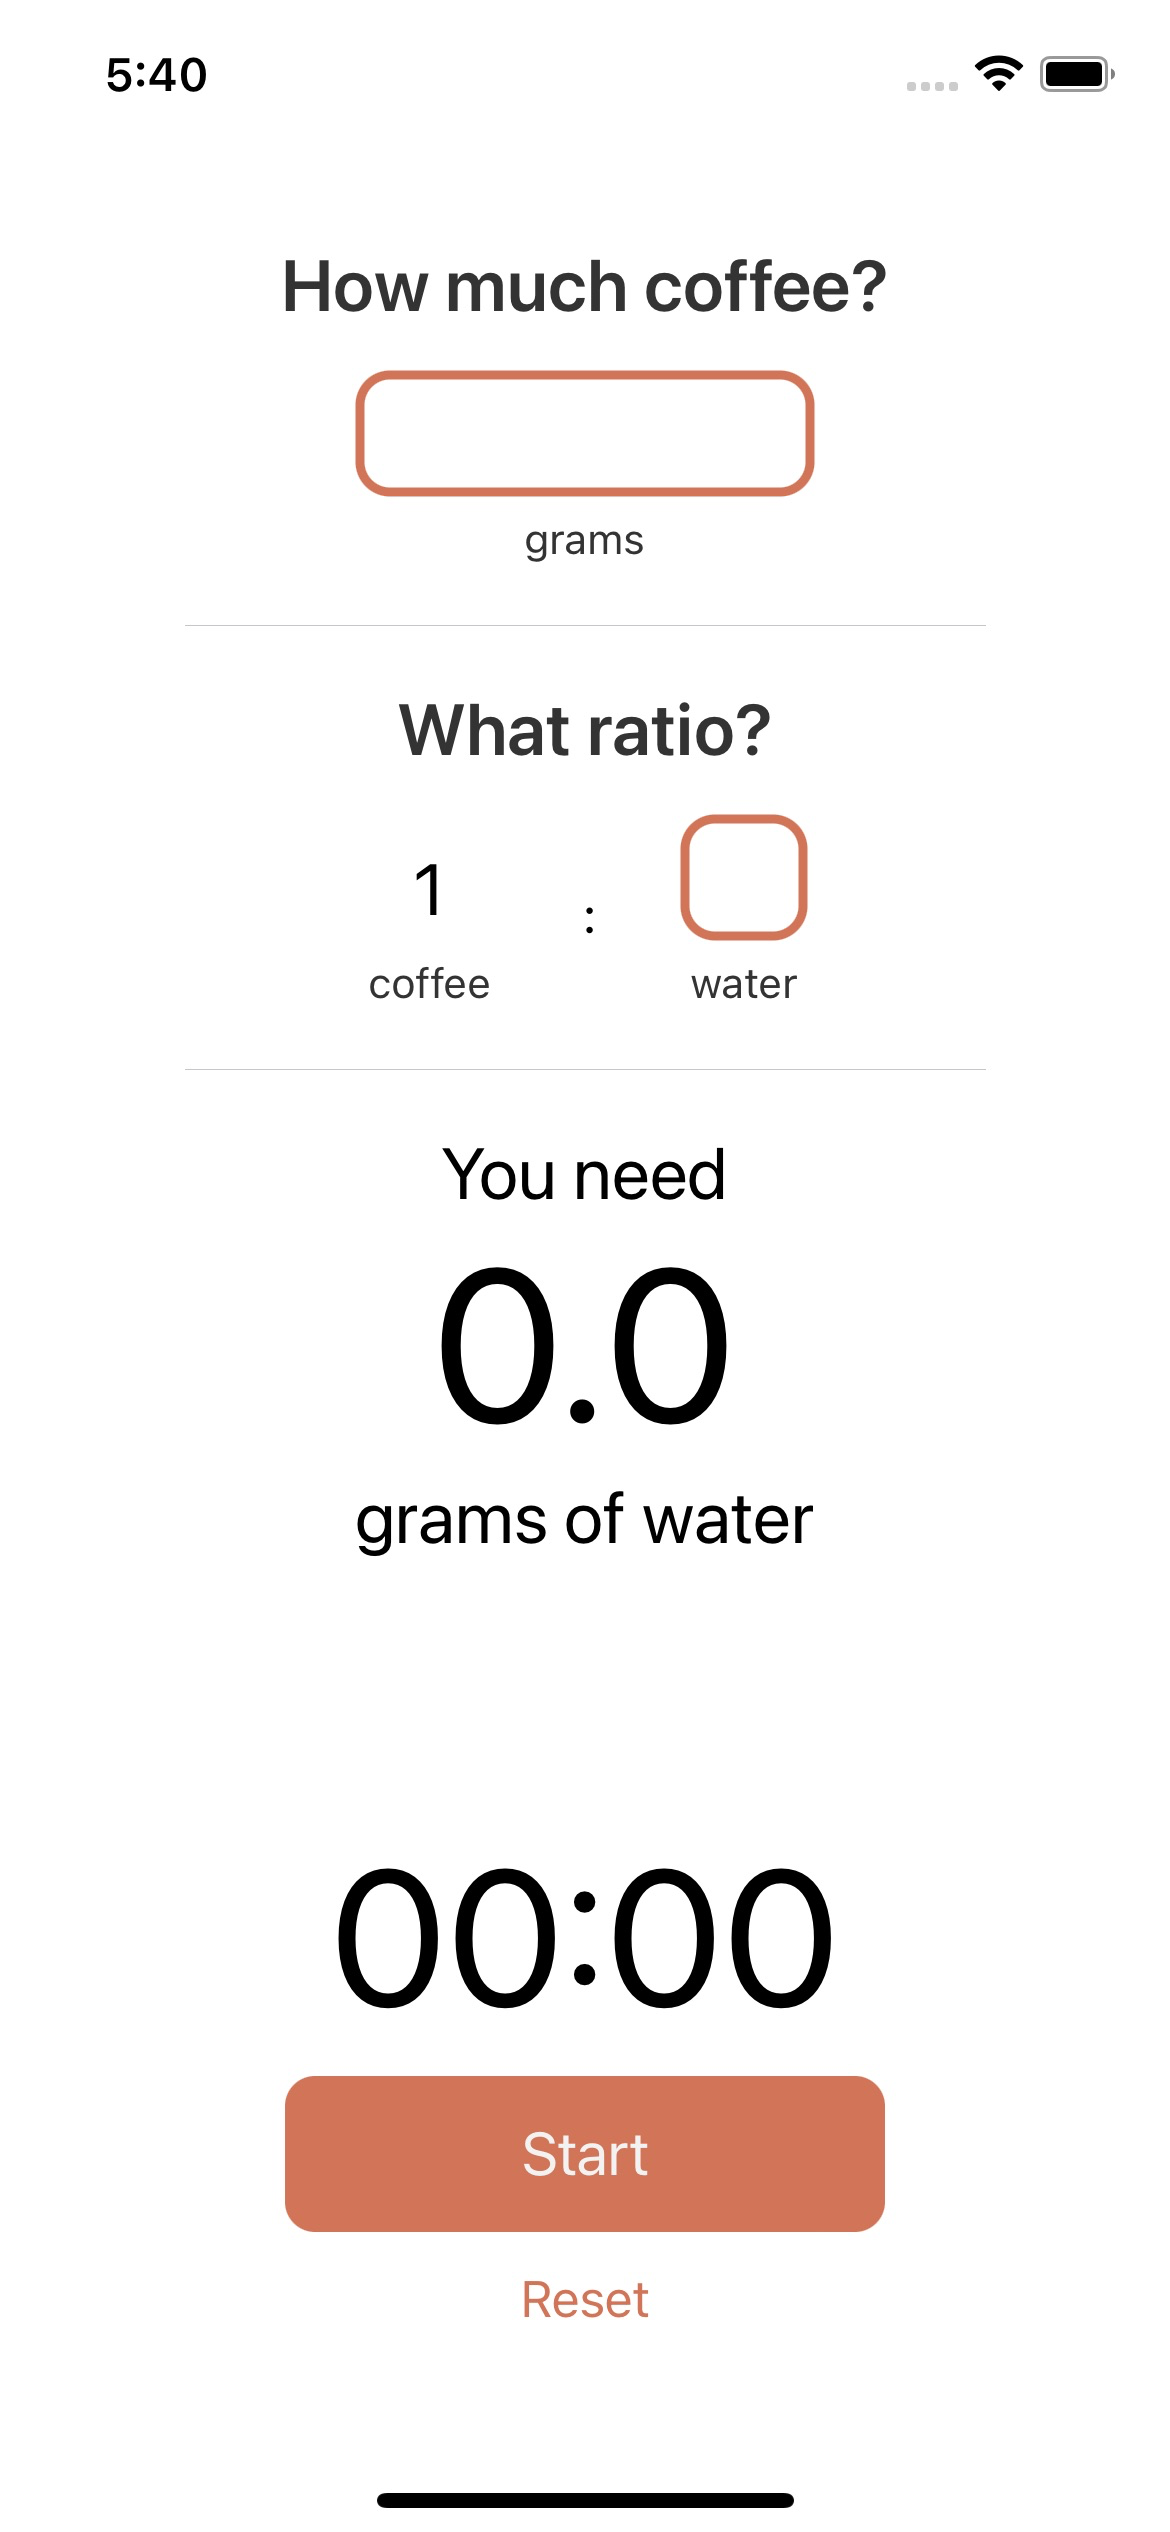

{'textfield_path': 'data/OSS/textfield_contexts/Ratios_1/157233290', 'textfield_info': {'type': 'XCUIElementTypeTextField', 'label': '', 'enabled': 'true', 'visible': 'true', 'accessible': 'true', 'x': '120', 'y': '133', 'width': '150', 'height': '23', 'index': '1'}, 'app_name': 'Ratios', 'screenshot_path': 'data/OSS/snapshots/Ratios/-1499365203/screenshot.png', 'textfield_tokens': [], 'local_context': ['much', 'coffee', 'how', 'grams', 'what', 'ratio', '1', 'coffee', 'water', 'need', 'you', '0', 'of', 'water', 'grams', '00', 'start', 'reset'], 'global_context': ['00', '0', 'of', 'start', '1', 'grams', 'water', 'much', 'ratios', 'coffee', 'what', 'need', 'you', 'how', 'reset', 'ratio']}

##23


source                                          data/textfield_features_OSS.json
app_name                                      de.kromke.andreas.opus1musicplayer
tf_path                        data/OSS/textfield_contexts/de.kromke.andreas....
pred_top1                                                          [search, app]
GT_categories                                   {'search': ['music', 'storage']}
pcat_rank                                                                      1
scat_rank                                                                      2
primary_categories_ranked      [(search, 0.4552300407240788), (description, 0...
secondary_categories_ranked    [(app, 0.5372341523567835), (storage, 0.606888...
Name: 22, dtype: object

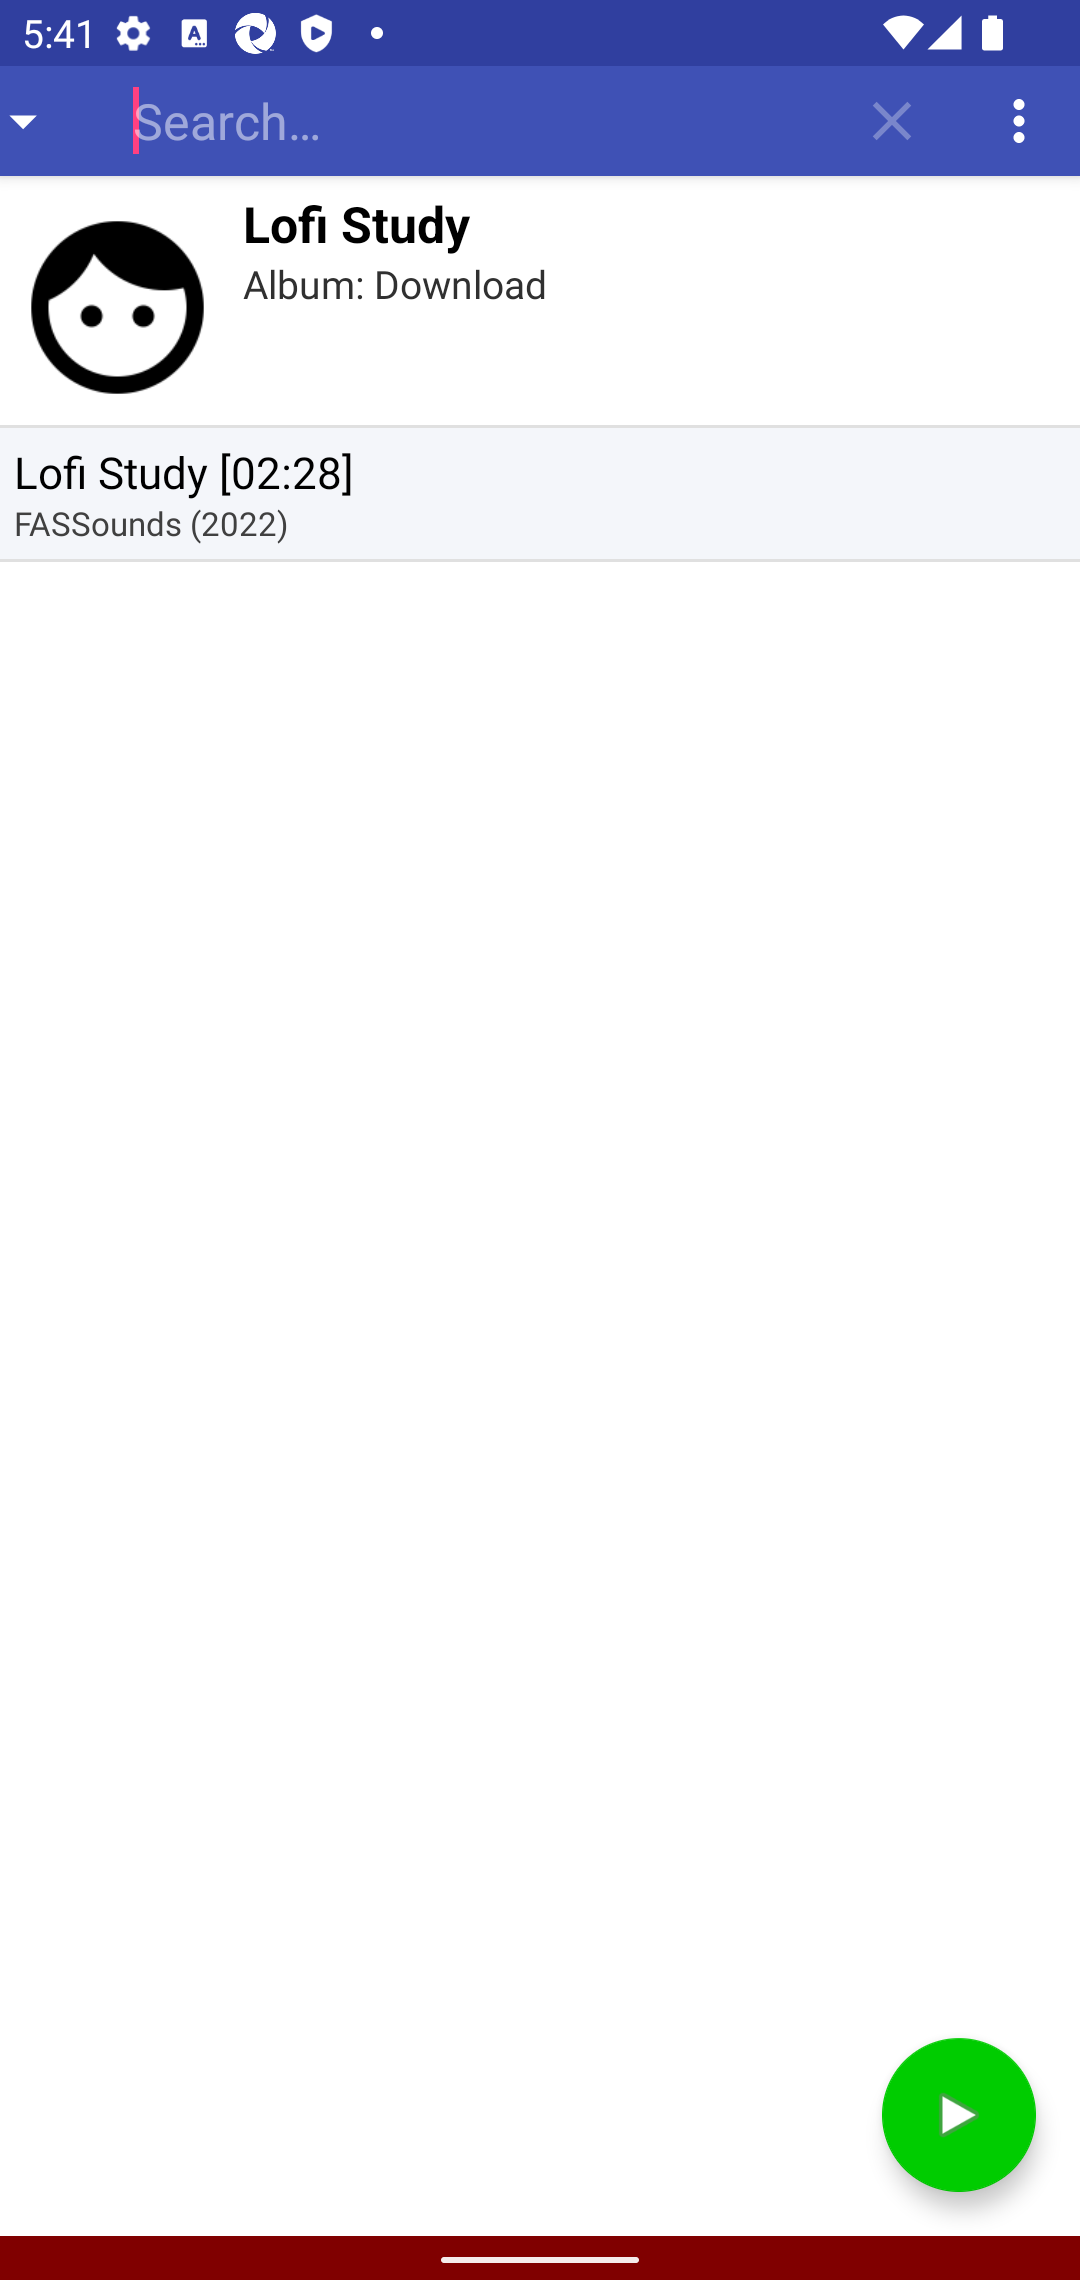

{'textfield_path': 'data/OSS/textfield_contexts/de.kromke.andreas.opus1musicplayer_1/search_src_text', 'textfield_info': {'index': '0', 'package': 'de.kromke.andreas.opus1musicplayer', 'class': 'android.widget.AutoCompleteTextView', 'text': 'Search…', 'resource-id': 'search_src_text', 'checkable': 'false', 'checked': 'false', 'clickable': 'true', 'enabled': 'true', 'focusable': 'true', 'focused': 'true', 'long-clickable': 'true', 'password': 'false', 'scrollable': 'false', 'selected': 'false', 'bounds': '[111,71][837,170]', 'displayed': 'true'}, 'app_name': 'de.kromke.andreas.opus1musicplayer', 'screenshot_path': 'data/OSS/snapshots/de.kromke.andreas.opus1musicplayer/1643267838/screenshot.png', 'textfield_tokens': ['search', 'src', 'text'], 'local_context': ['search', 'plate', 'search', 'src', 'text', 'btn', 'clear', 'close', 'query', 'search'], 'global_context': ['container', '02', 'fas', 'spinner', 'close', 'sounds', '2022', 'download', 'album', 'action', 'app', 'track', '28', 'clear

source                                          data/textfield_features_OSS.json
app_name                                                   Plex_Stream_Movies_TV
tf_path                        data/OSS/textfield_contexts/Plex_Stream_Movies...
pred_top1                                                        [search, music]
GT_categories                                              {'search': ['movie']}
pcat_rank                                                                      1
scat_rank                                                                     11
primary_categories_ranked      [(search, 0.34821588223179184), (music, 0.4757...
secondary_categories_ranked    [(music, 0.6064514455695946), (location, 0.611...
Name: 38, dtype: object

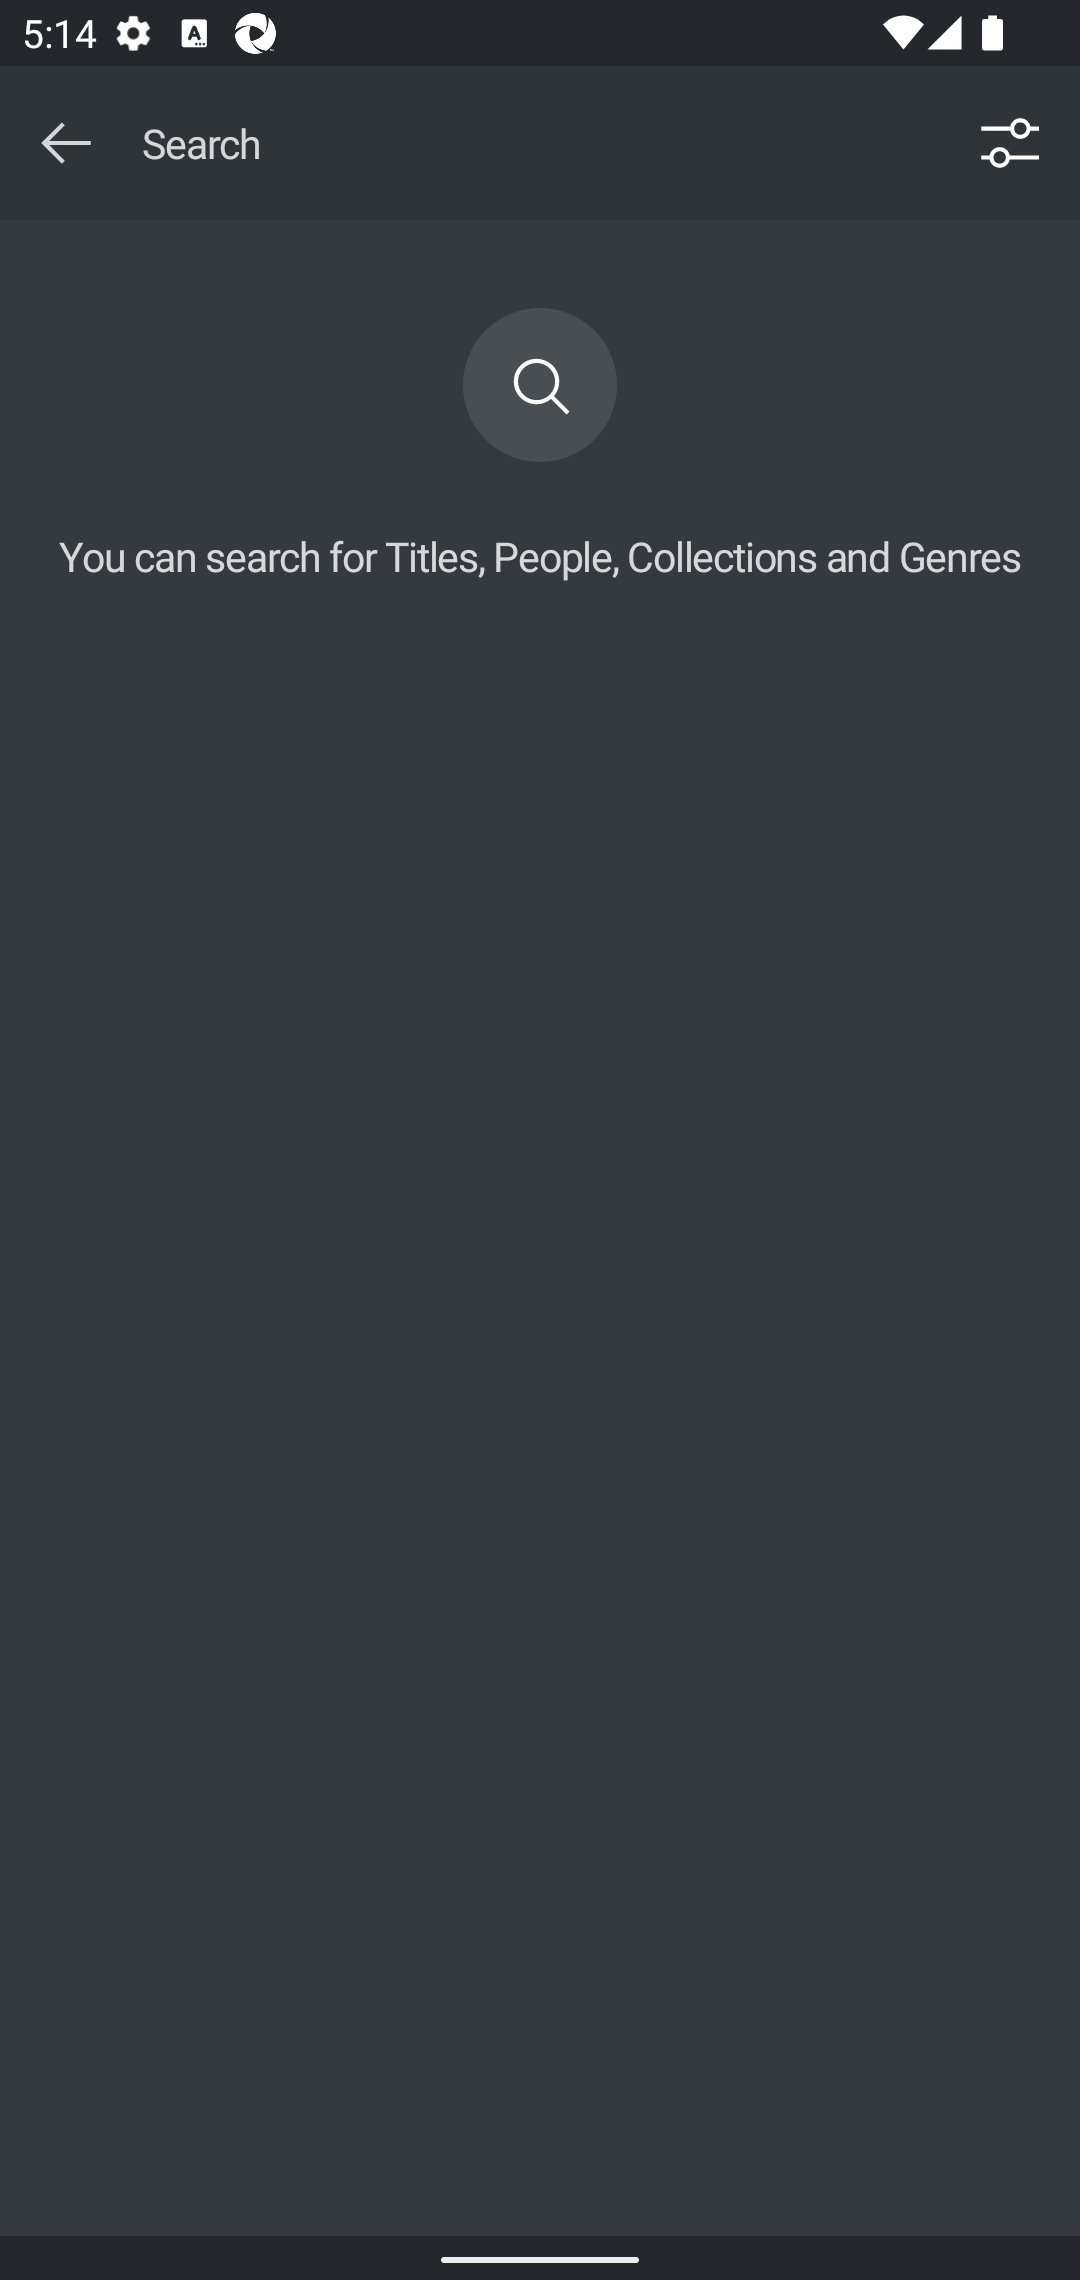

{'textfield_path': 'data/OSS/textfield_contexts/Plex_Stream_Movies_TV_1/-1469543694', 'textfield_info': {'index': '0', 'package': 'com.plexapp.android', 'class': 'android.widget.EditText', 'text': '', 'checkable': 'false', 'checked': 'false', 'clickable': 'true', 'enabled': 'true', 'focusable': 'true', 'focused': 'true', 'long-clickable': 'true', 'password': 'false', 'scrollable': 'false', 'selected': 'false', 'bounds': '[0,66][939,220]', 'displayed': 'true'}, 'app_name': 'Plex_Stream_Movies_TV', 'screenshot_path': 'data/OSS/snapshots/Plex_Stream_Movies_TV/2009846125/screenshot.png', 'textfield_tokens': [], 'local_context': ['people', 'for', 'collections', 'and', 'you', 'search', 'titles', 'genres', 'can'], 'global_context': ['action', 'bar', 'container', 'people', 'for', 'collections', 'and', 'fragment', 'root', 'you', 'navigation', 'content', 'background', 'search', 'titles', 'genres', 'can']}

##42


source                                          data/textfield_features_OSS.json
app_name                                             AOL_News_Mail_Video_v6.47.2
tf_path                        data/OSS/textfield_contexts/AOL_News_Mail_Vide...
pred_top1                                                          [search, app]
GT_categories                                      {'search': ['news', 'video']}
pcat_rank                                                                      1
scat_rank                                                                      5
primary_categories_ranked      [(search, 0.4527788343528906), (description, 0...
secondary_categories_ranked    [(app, 0.5884032882750034), (storage, 0.610802...
Name: 41, dtype: object

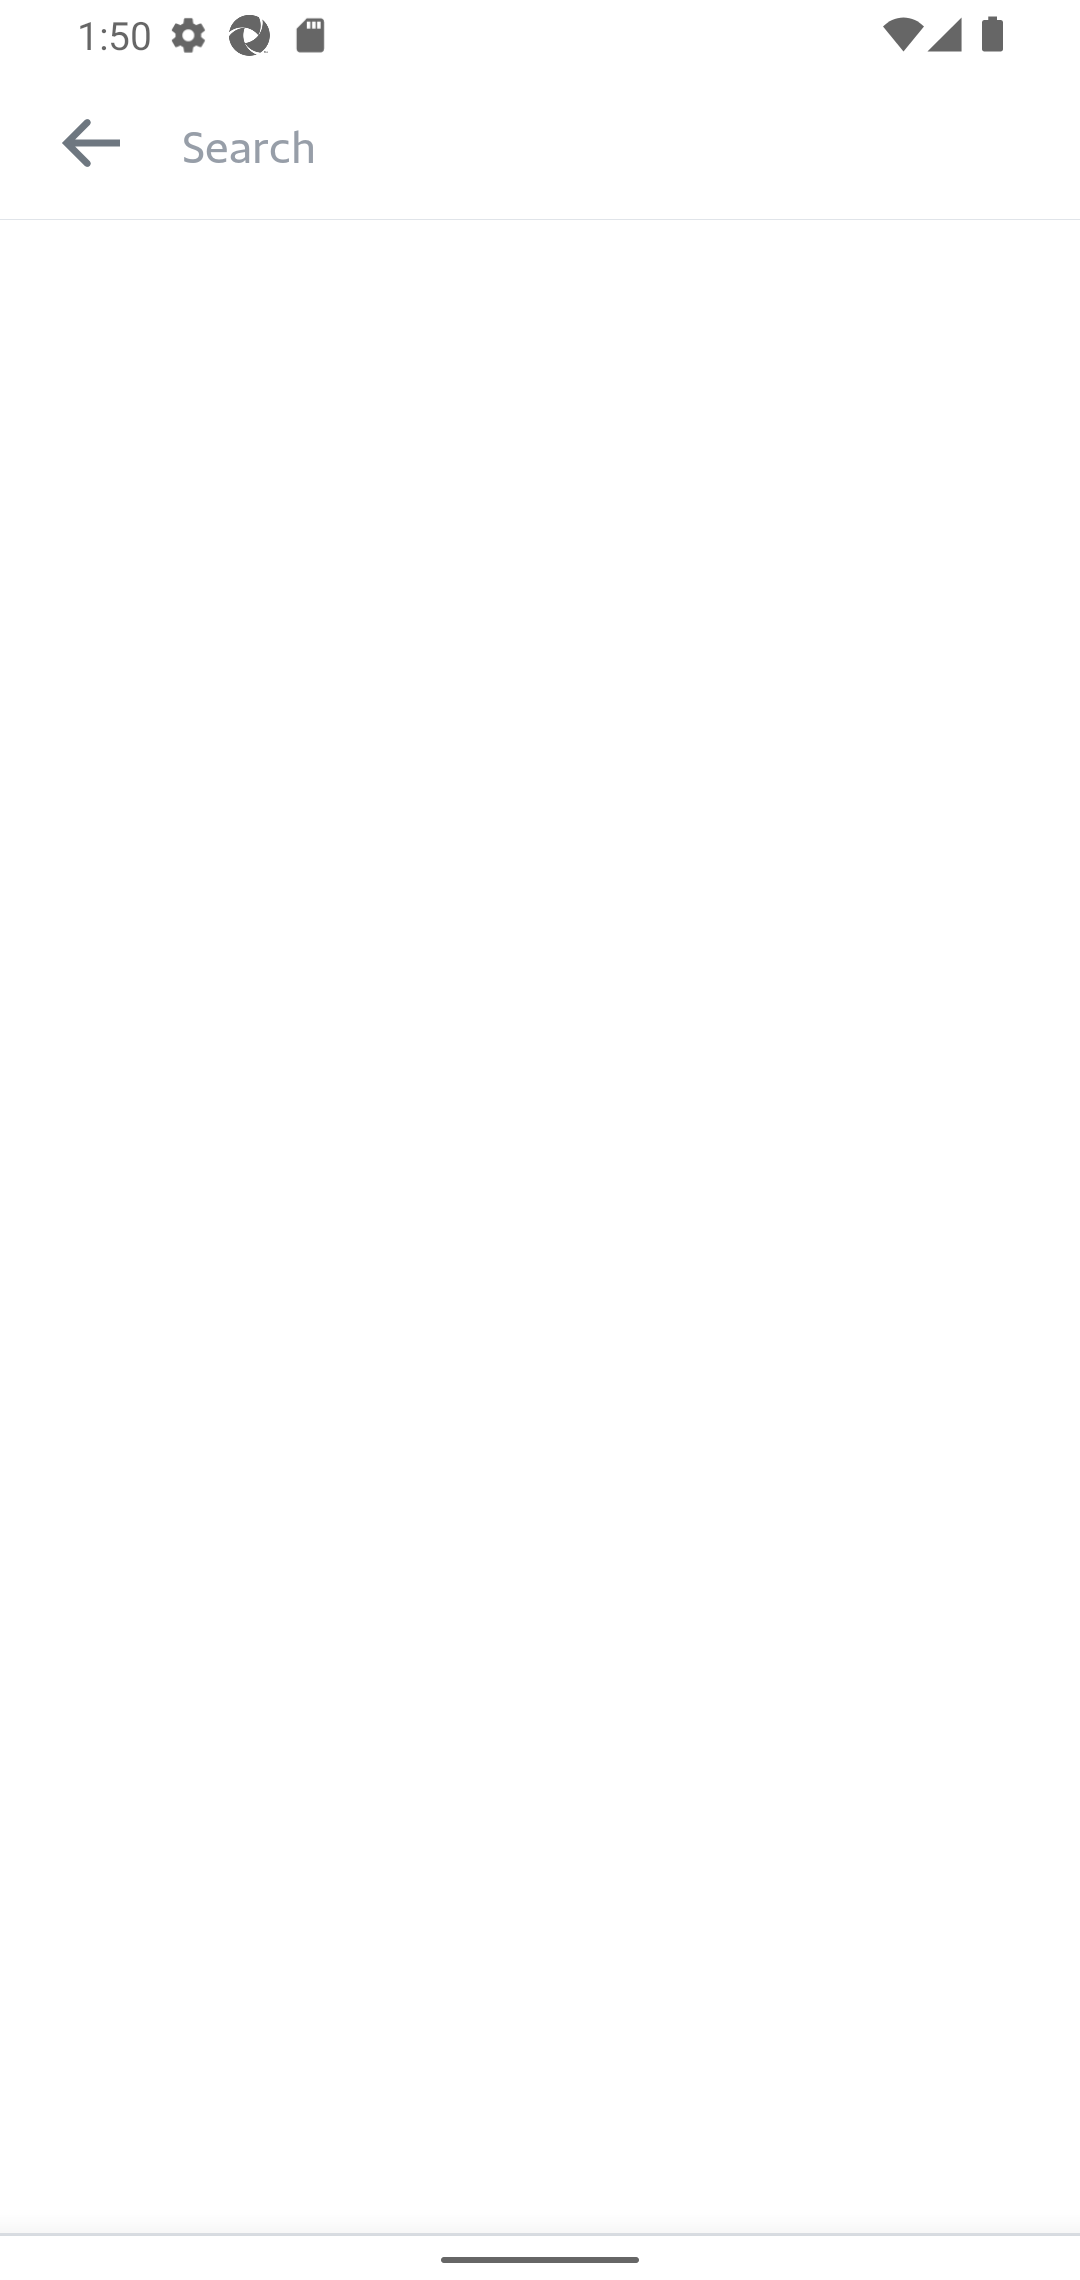

{'textfield_path': 'data/OSS/textfield_contexts/AOL_News_Mail_Video_v6.47.2_1/search_edit_text', 'textfield_info': {'index': '1', 'package': 'com.aol.mobile.aolapp', 'class': 'android.widget.EditText', 'text': 'Search', 'resource-id': 'search_edit_text', 'checkable': 'false', 'checked': 'false', 'clickable': 'true', 'enabled': 'true', 'focusable': 'true', 'focused': 'false', 'long-clickable': 'true', 'password': 'false', 'scrollable': 'false', 'selected': 'false', 'bounds': '[182,66][1080,220]', 'displayed': 'true'}, 'app_name': 'AOL_News_Mail_Video_v6.47.2', 'screenshot_path': 'data/OSS/snapshots/AOL_News_Mail_Video_v6.47.2/-2077864795/screenshot.png', 'textfield_tokens': ['search', 'edit', 'text'], 'local_context': ['search', 'chipped', 'box', 'search', 'edit', 'text'], 'global_context': ['container', 'shadow', 'include', 'toast', 'left', 'action', 'app', 'divider', 'drawer', 'fragment', 'suggestion', 'content', 'background', 'search', 'view', 'toolbar', 'button', 'refresh', 'layout'

source                                          data/textfield_features_OSS.json
app_name                                      Issuu_magazines_news_books_v5.67.0
tf_path                        data/OSS/textfield_contexts/Issuu_magazines_ne...
pred_top1                                                      [search, storage]
GT_categories                           {'search': ['megazine', 'book', 'news']}
pcat_rank                                                                      1
scat_rank                                                                      2
primary_categories_ranked      [(search, 0.4438951211671034), (description, 0...
secondary_categories_ranked    [(storage, 0.5350351060430208), (megazine, 0.6...
Name: 62, dtype: object

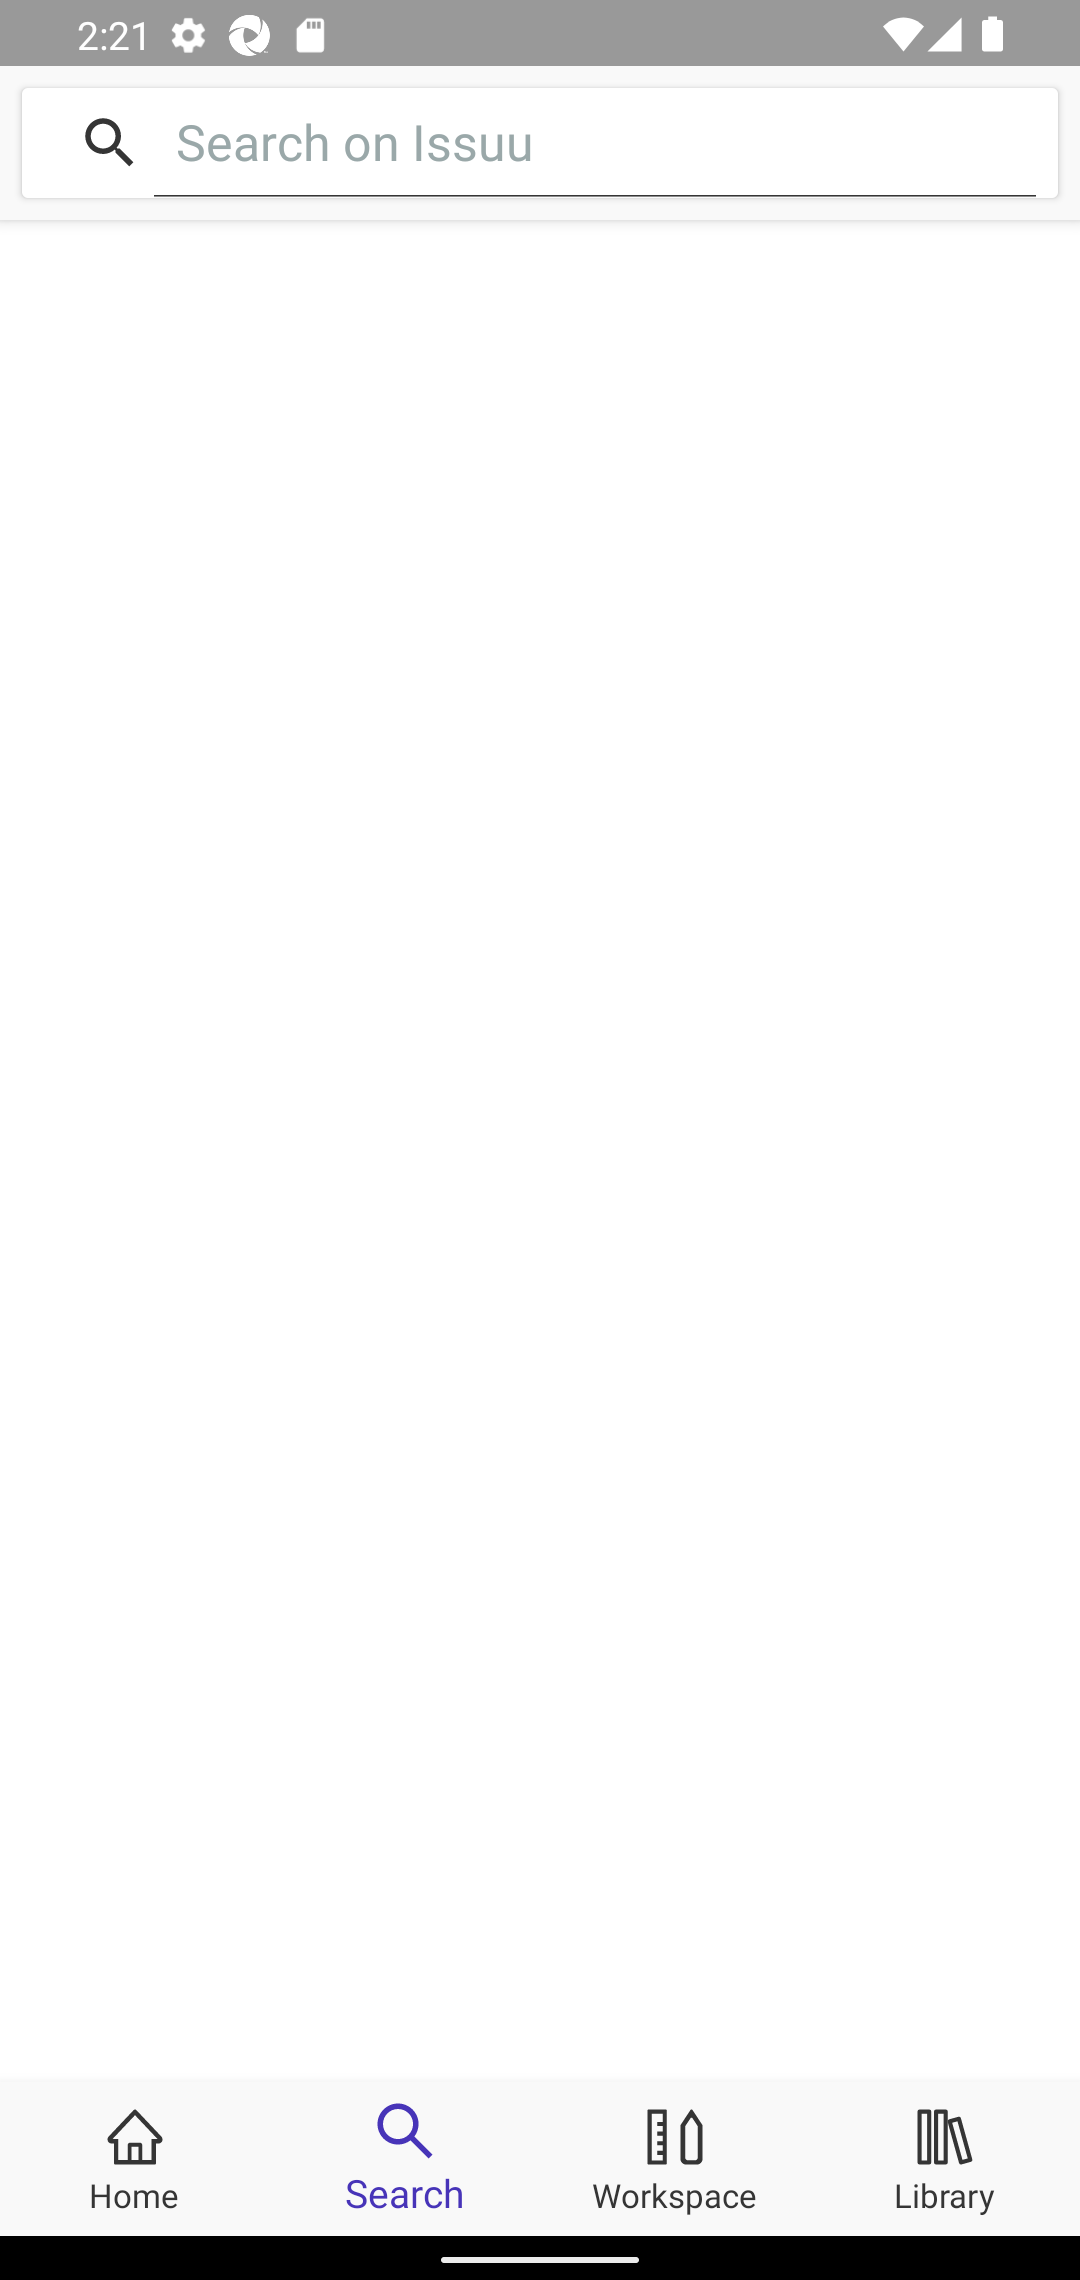

{'textfield_path': 'data/OSS/textfield_contexts/Issuu_magazines_news_books_v5.67.0_1/search_src_text', 'textfield_info': {'index': '0', 'package': 'com.issuu.android.app', 'class': 'android.widget.AutoCompleteTextView', 'text': 'Search on Issuu', 'resource-id': 'search_src_text', 'checkable': 'false', 'checked': 'false', 'clickable': 'true', 'enabled': 'true', 'focusable': 'true', 'focused': 'false', 'long-clickable': 'true', 'password': 'false', 'scrollable': 'false', 'selected': 'false', 'bounds': '[154,92][1036,191]', 'displayed': 'true'}, 'app_name': 'Issuu_magazines_news_books_v5.67.0', 'screenshot_path': 'data/OSS/snapshots/Issuu_magazines_news_books_v5.67.0/-514105064/screenshot.png', 'textfield_tokens': ['issuu', 'src', 'text', 'search', 'on'], 'local_context': ['search', 'plate', 'issuu', 'src', 'text', 'search', 'on'], 'global_context': ['pager', 'large', 'icon', 'on', 'home', 'action', 'group', 'labels', 'tab', 'issuu', 'content', 'src', 'background', 'search', 'view', 'smal

source                                      data/textfield_features_samsung.json
app_name                                                                Messages
tf_path                        data/samsung_internal/Messages/state_2022-11-0...
pred_top1                                                          [search, web]
GT_categories                  {'messenger': ['recipient', 'message'], 'searc...
pcat_rank                                                                      1
scat_rank                                                                      2
primary_categories_ranked      [(search, 0.4556399515519539), (auth_code, 0.6...
secondary_categories_ranked    [(web, 0.7136156621078651), (storage, 0.729493...
Name: 77, dtype: object

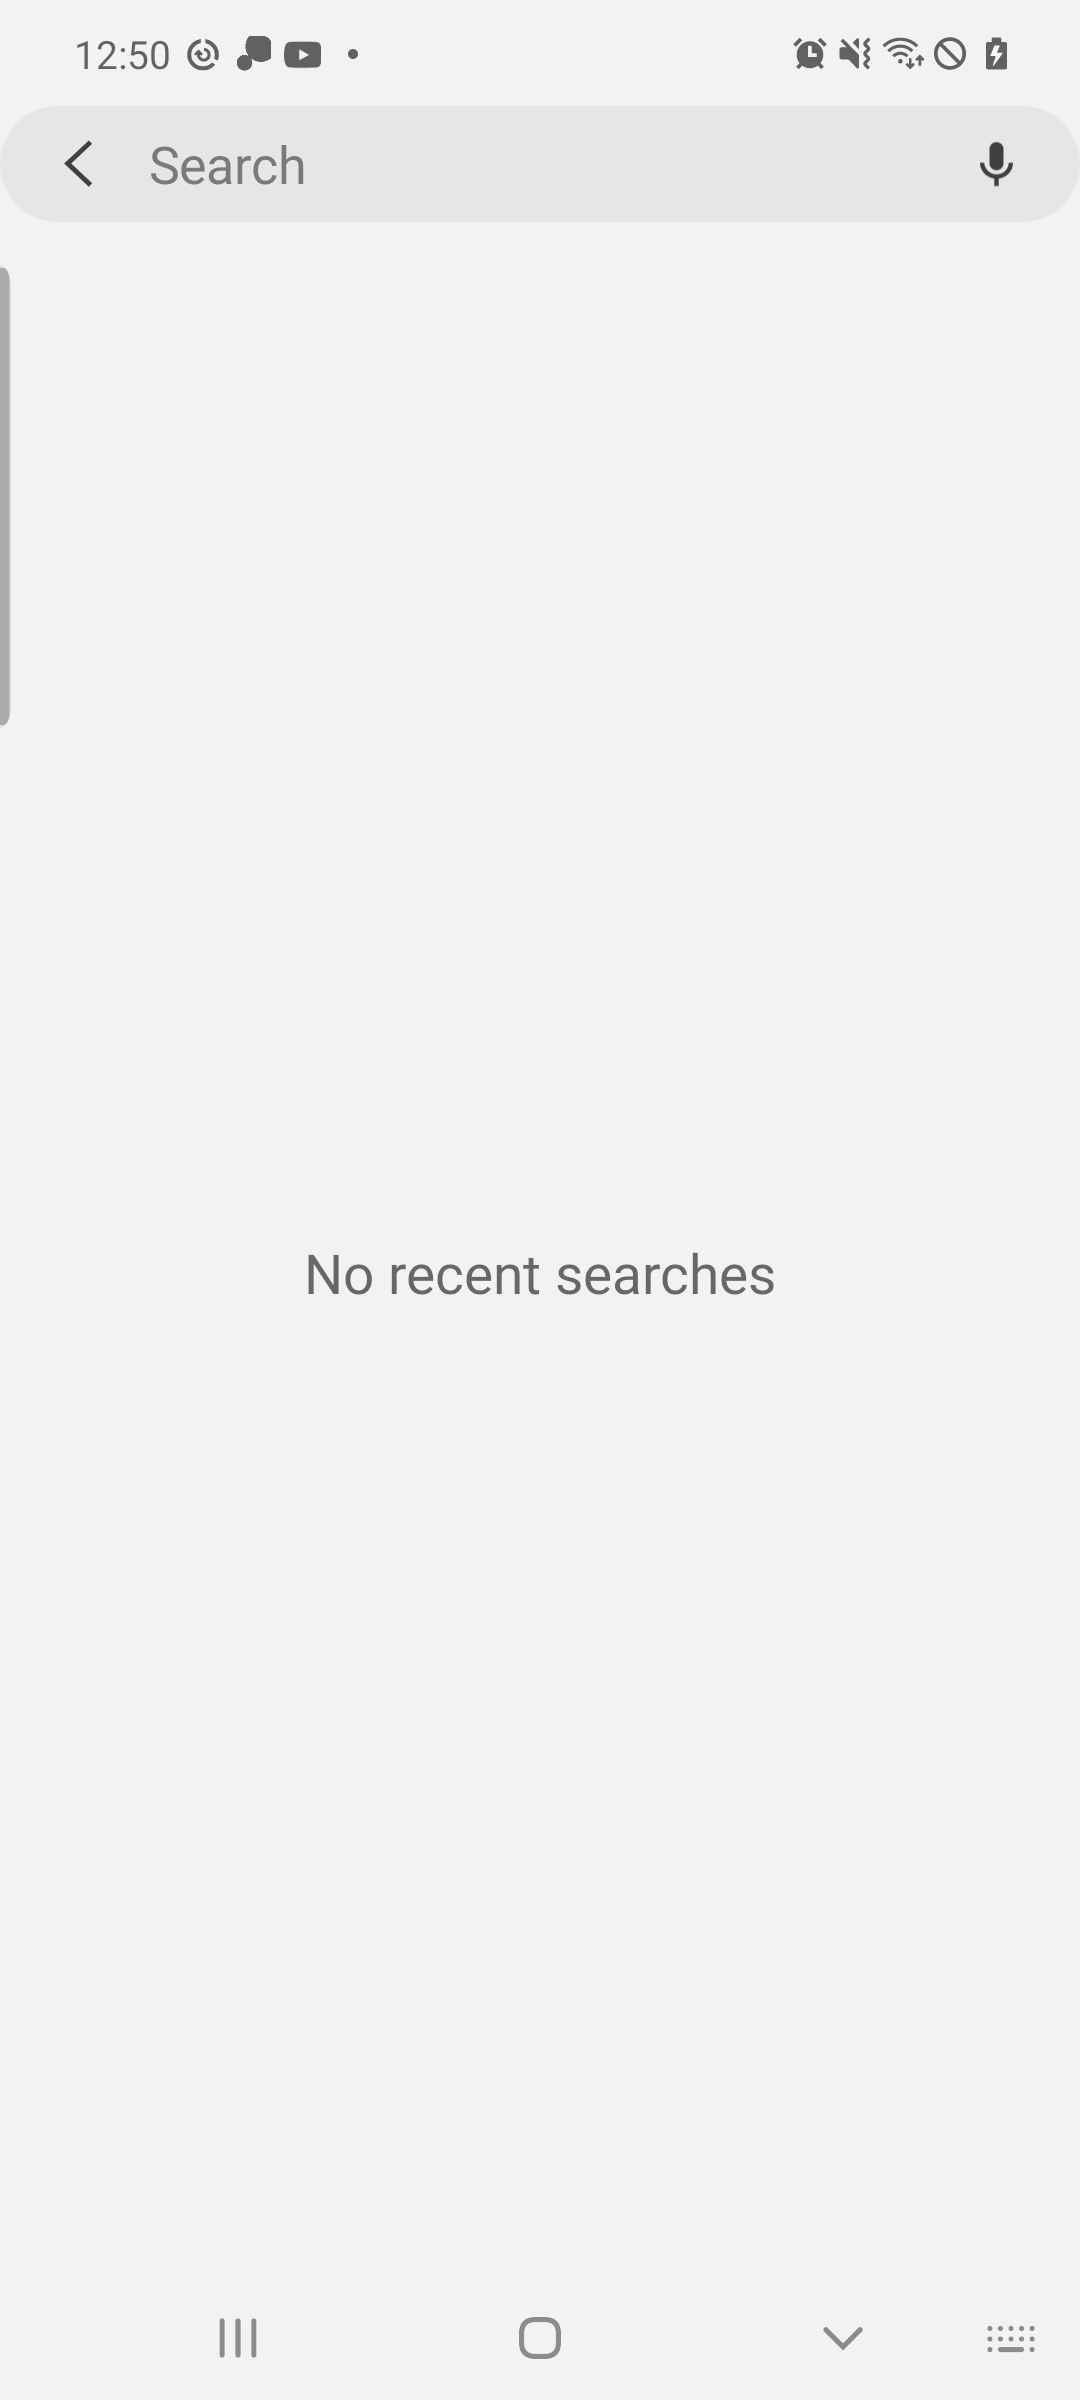

{'textfield_path': 'data/samsung_internal/Messages/state_2022-11-01_125025142665.json:search_src_text', 'textfield_info': {'activity_name': 'com.samsung.android.messaging/.ui.view.search.SearchActivity', 'resource_id': 'com.samsung.android.messaging:id/search_src_text', 'class': 'android.widget.EditText', 'pointer': 'None', 'content_desc': 'None', 'enabled': 'true', 'visible': 'true', 'checked': 'false', 'selected': 'false', 'editable': 'true', 'clickable': 'true', 'long_clickable': 'true', 'scrollable_horizontal': 'false', 'scrollable_vertical': 'false', 'checkable': 'false', 'text': 'Search', 'text_hint': 'None', 'bounds': '[138, 106, 905, 222]', 'rel_bounds': '[138, 106, 905, 222]', 'uid': '8c85784f95fbb509751684c1409cf168', 'serialize_class': 'AndroidViewTree', 'package_name': 'com.samsung.android.messaging', 'fingerprint': '', 'type': 'textfield', 'resource-id': 'search_src_text', 'content-desc': 'None'}, 'app_name': 'Messages', 'screenshot_path': 'data/samsung_internal/Messages/s

source                                      data/textfield_features_samsung.json
app_name                                                                Contacts
tf_path                        data/samsung_internal/Contacts/state_2022-11-0...
pred_top1                                                          [search, web]
GT_categories                                            {'search': ['storage']}
pcat_rank                                                                      1
scat_rank                                                                      2
primary_categories_ranked      [(search, 0.4556399515519539), (auth_code, 0.6...
secondary_categories_ranked    [(web, 0.7136156621078651), (storage, 0.729493...
Name: 84, dtype: object

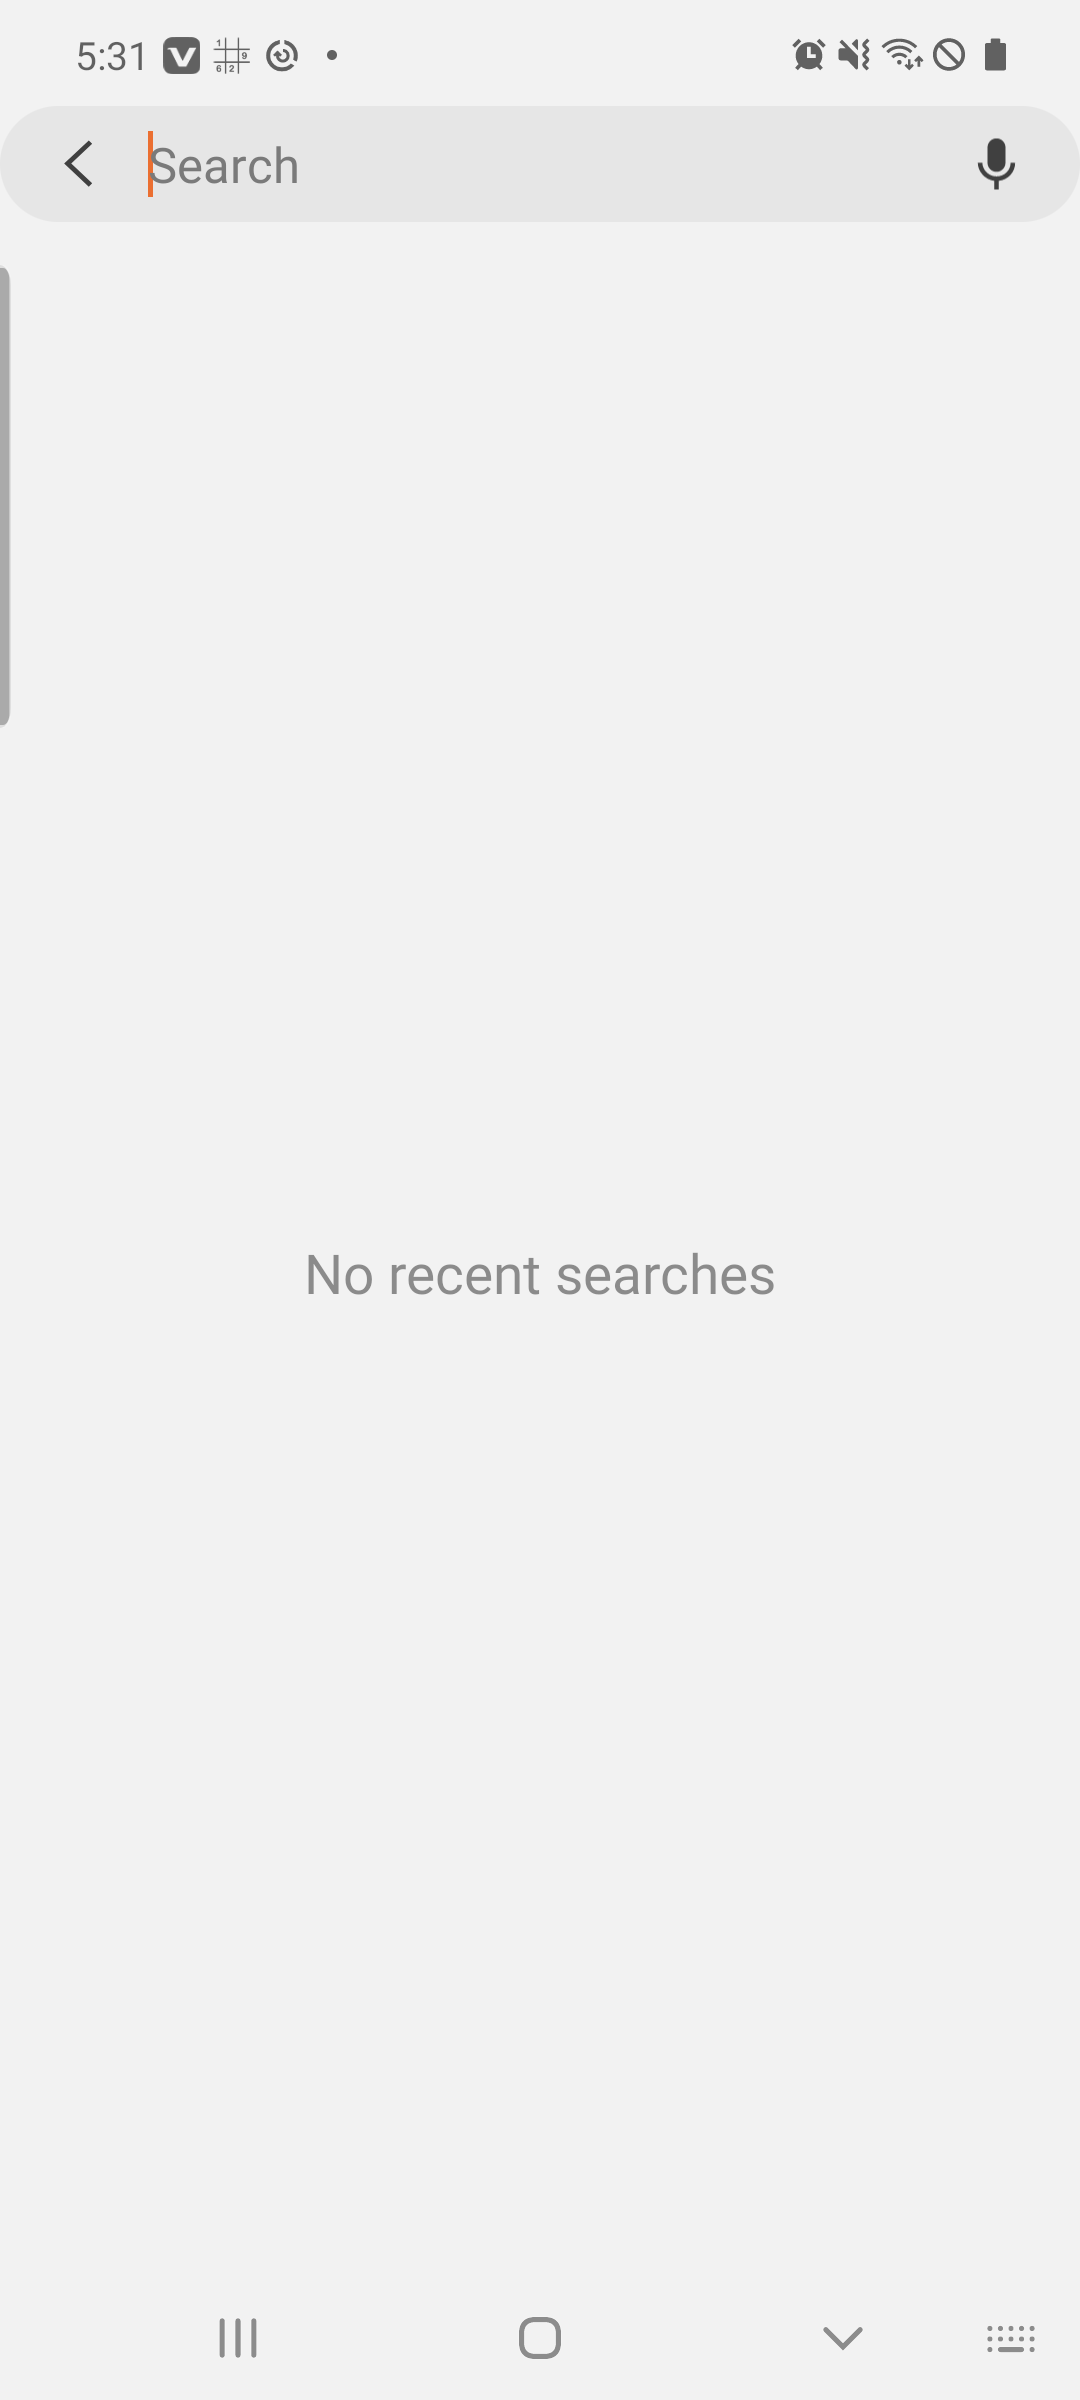

{'textfield_path': 'data/samsung_internal/Contacts/state_2022-11-01_173146572934.json:search_src_text', 'textfield_info': {'activity_name': 'com.samsung.android.app.contacts/com.samsung.android.contacts.search.activity.ContactSearchActivity', 'resource_id': 'com.samsung.android.app.contacts:id/search_src_text', 'class': 'android.widget.EditText', 'pointer': 'None', 'content_desc': 'None', 'enabled': 'true', 'visible': 'true', 'checked': 'false', 'selected': 'false', 'editable': 'true', 'clickable': 'true', 'long_clickable': 'true', 'scrollable_horizontal': 'false', 'scrollable_vertical': 'false', 'checkable': 'false', 'text': 'Search', 'text_hint': 'None', 'bounds': '[137, 106, 939, 222]', 'rel_bounds': '[137, 106, 939, 222]', 'uid': '53f4b26f263bd2f20df915dd16db744e', 'serialize_class': 'AndroidViewTree', 'package_name': 'com.samsung.android.app.contacts', 'fingerprint': '', 'type': 'textfield', 'resource-id': 'search_src_text', 'content-desc': 'None'}, 'app_name': 'Contacts', 'screen

source                                      data/textfield_features_samsung.json
app_name                                                                Contacts
tf_path                        data/samsung_internal/Contacts/state_2022-11-0...
pred_top1                                                       [profile, email]
GT_categories                                              {'profile': ['name']}
pcat_rank                                                                      1
scat_rank                                                                      5
primary_categories_ranked      [(profile, 0.5329538544019062), (auth_code, 0....
secondary_categories_ranked    [(email, 0.48009251927336055), (job, 0.5335688...
Name: 85, dtype: object

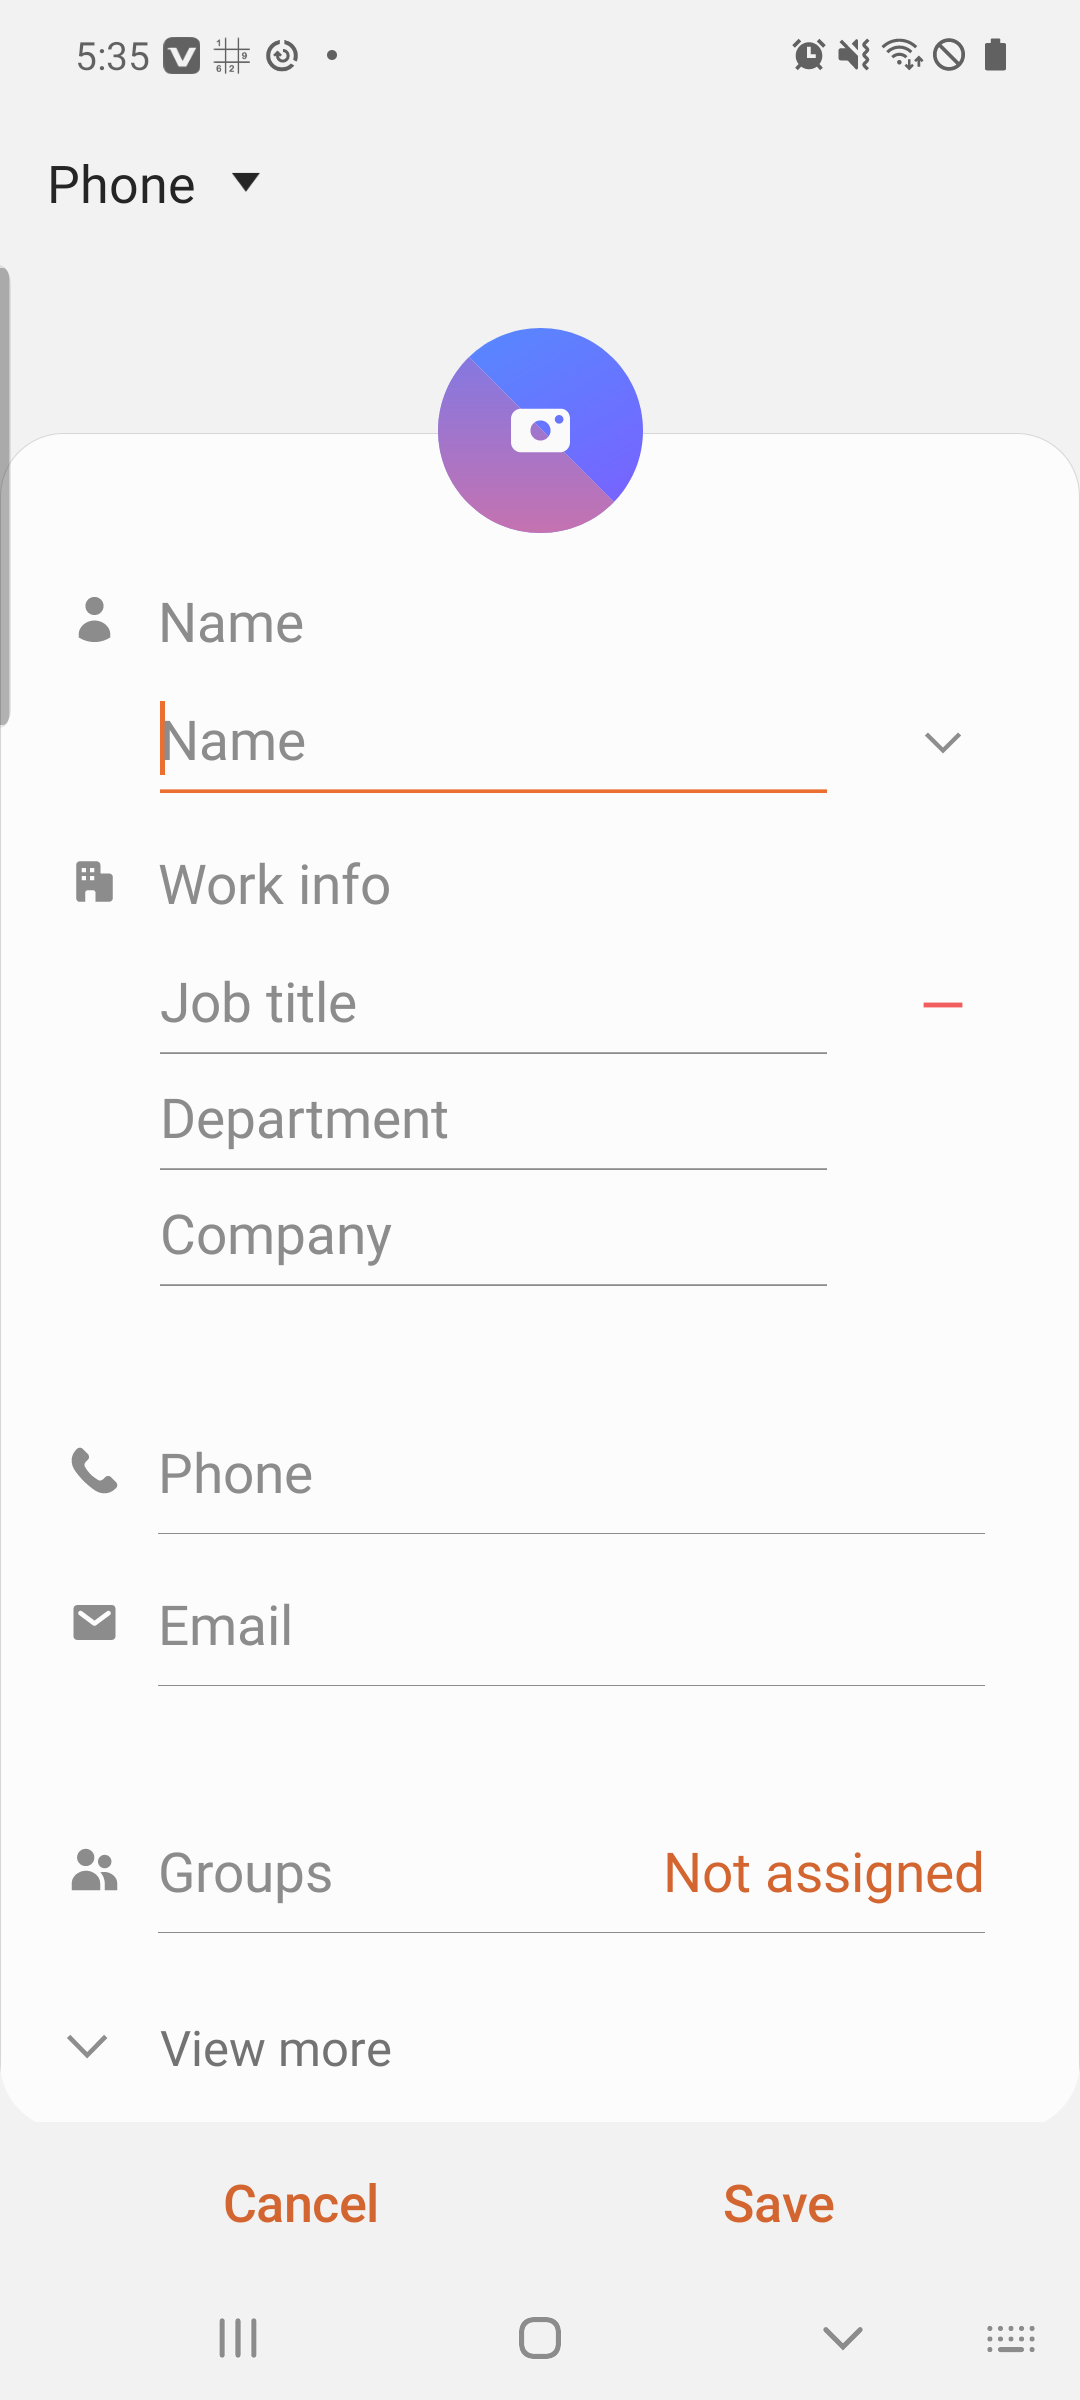

{'textfield_path': 'data/samsung_internal/Contacts/state_2022-11-01_173529930391.json:forCursorEdit', 'textfield_info': {'activity_name': 'com.samsung.android.app.contacts/com.samsung.android.contacts.editor.ContactEditorActivity', 'resource_id': 'com.samsung.android.app.contacts:id/forCursorEdit', 'class': 'android.widget.EditText', 'pointer': 'None', 'content_desc': 'None', 'enabled': 'false', 'visible': 'true', 'checked': 'false', 'selected': 'false', 'editable': 'true', 'clickable': 'true', 'long_clickable': 'true', 'scrollable_horizontal': 'false', 'scrollable_vertical': 'false', 'checkable': 'false', 'text': '', 'text_hint': 'None', 'bounds': '[158, 1807, 161, 1810]', 'rel_bounds': '[158, 1807, 161, 1810]', 'uid': '1e448d0258cc03c19ea0e0d4395b3c6c', 'serialize_class': 'AndroidViewTree', 'package_name': 'com.samsung.android.app.contacts', 'fingerprint': '', 'type': 'textfield', 'resource-id': 'forCursorEdit', 'content-desc': 'None'}, 'app_name': 'Contacts', 'screenshot_path': 'dat

source                                      data/textfield_features_samsung.json
app_name                                                                Settings
tf_path                        data/samsung_internal/Settings/state_2022-11-0...
pred_top1                                                          [search, web]
GT_categories                                            {'search': ['storage']}
pcat_rank                                                                      1
scat_rank                                                                      2
primary_categories_ranked      [(search, 0.4556399515519539), (auth_code, 0.6...
secondary_categories_ranked    [(web, 0.7092171261707942), (storage, 0.723324...
Name: 90, dtype: object

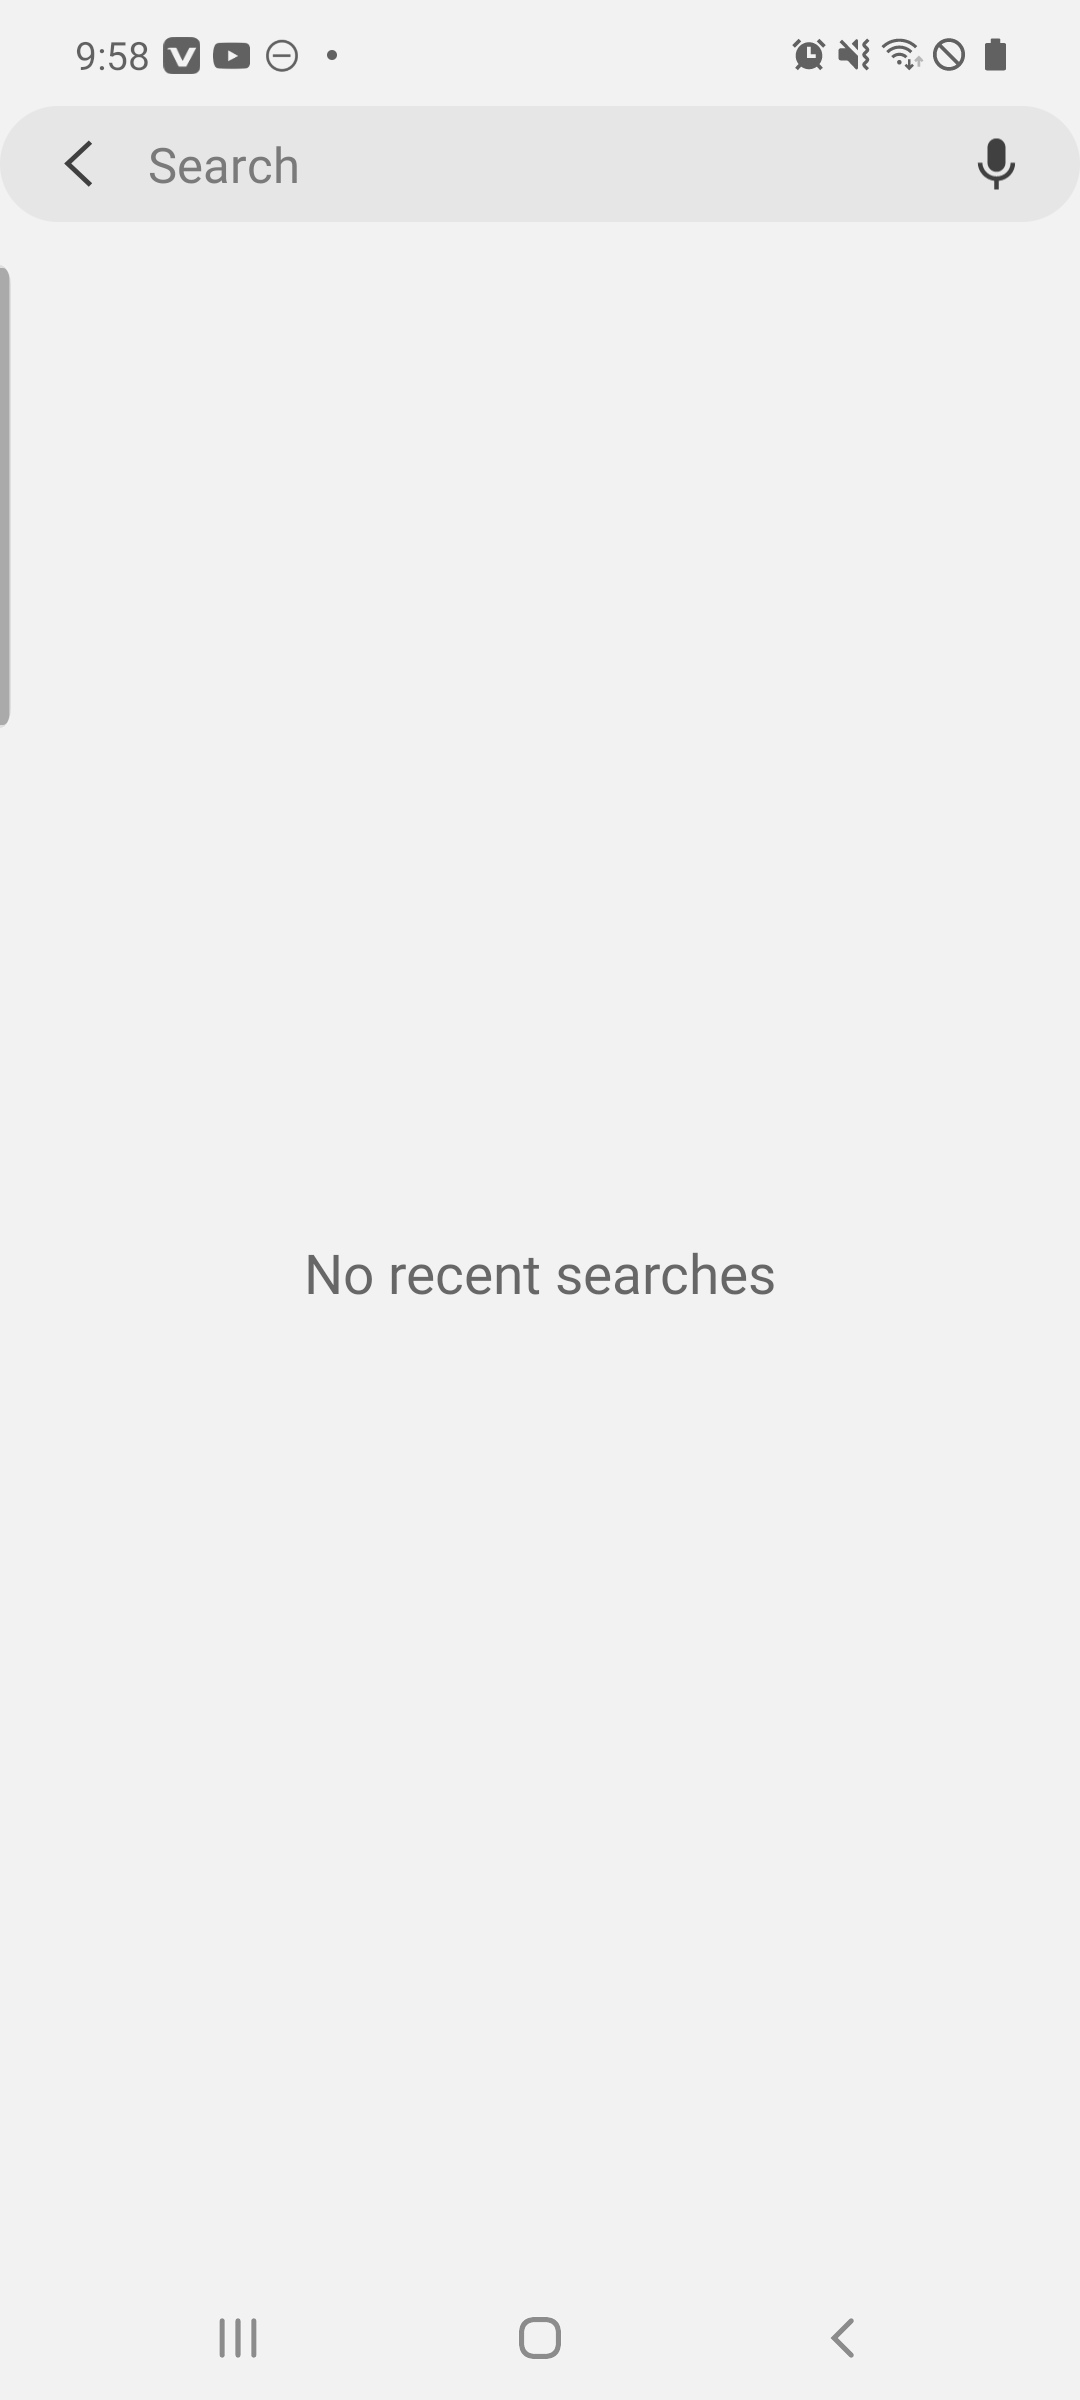

{'textfield_path': 'data/samsung_internal/Settings/state_2022-11-02_095831401950.json:search_src_text', 'textfield_info': {'activity_name': 'com.android.settings.intelligence/.search.SearchActivity', 'resource_id': 'com.android.settings.intelligence:id/search_src_text', 'class': 'android.widget.EditText', 'pointer': 'None', 'content_desc': 'None', 'enabled': 'true', 'visible': 'true', 'checked': 'false', 'selected': 'false', 'editable': 'true', 'clickable': 'true', 'long_clickable': 'true', 'scrollable_horizontal': 'false', 'scrollable_vertical': 'false', 'checkable': 'false', 'text': 'Search', 'text_hint': 'None', 'bounds': '[137, 106, 939, 222]', 'rel_bounds': '[137, 106, 939, 222]', 'uid': '404a601fefa91af674bd3406a4da7f77', 'serialize_class': 'AndroidViewTree', 'package_name': 'com.android.settings.intelligence', 'fingerprint': '', 'type': 'textfield', 'resource-id': 'search_src_text', 'content-desc': 'None'}, 'app_name': 'Settings', 'screenshot_path': 'data/samsung_internal/Settin

source                                      data/textfield_features_samsung.json
app_name                                                                 Gallery
tf_path                        data/samsung_internal/Gallery/state_2022-11-01...
pred_top1                                                        [search, video]
GT_categories                                            {'search': ['storage']}
pcat_rank                                                                      1
scat_rank                                                                      2
primary_categories_ranked      [(search, 0.4717918990800778), (description, 0...
secondary_categories_ranked    [(video, 0.4799034545818965), (storage, 0.5821...
Name: 93, dtype: object

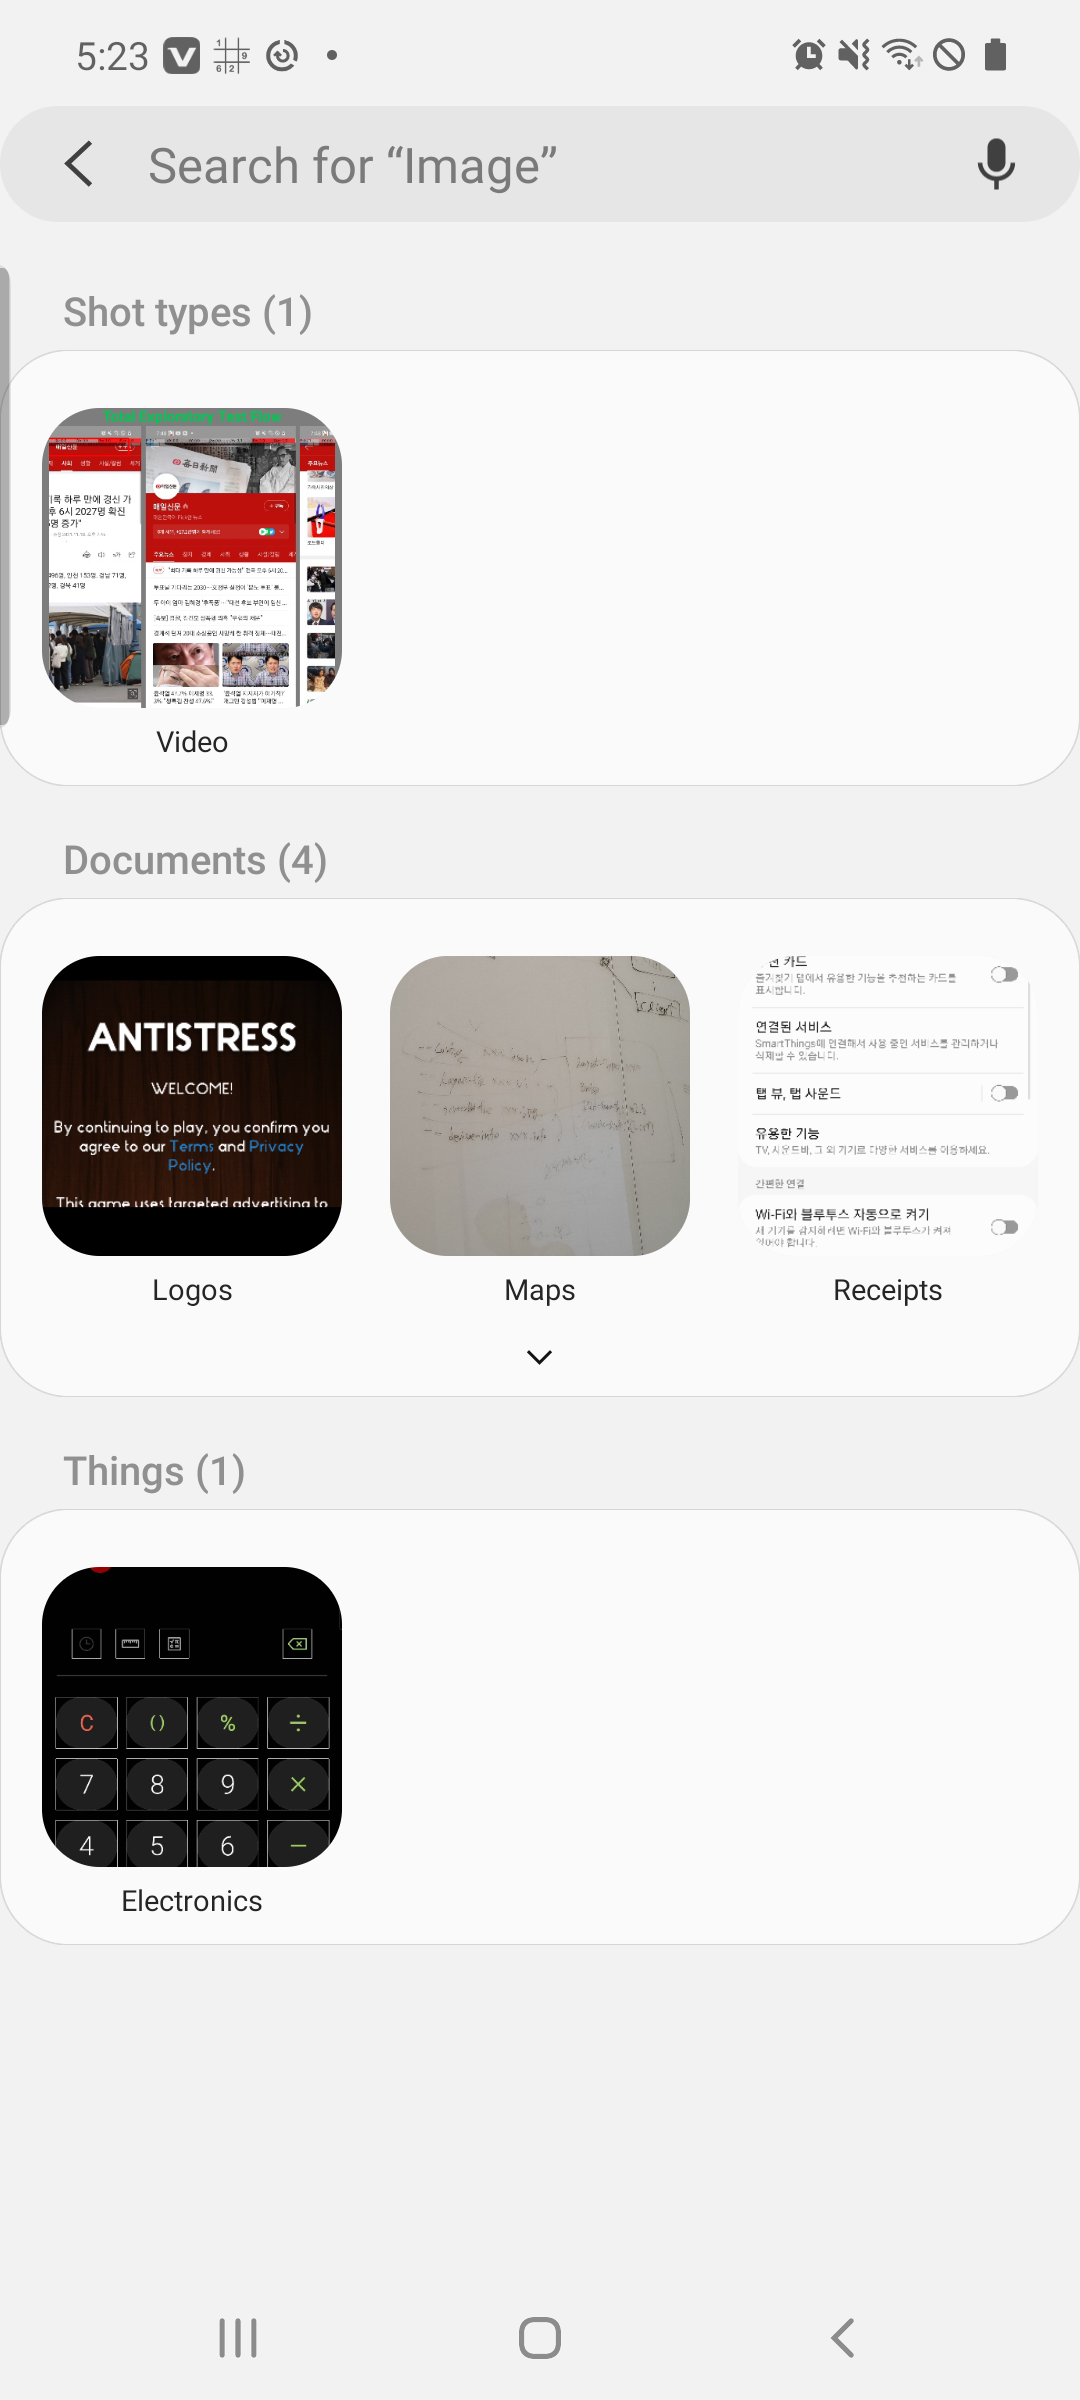

{'textfield_path': 'data/samsung_internal/Gallery/state_2022-11-01_172316447819.json:search_src_text', 'textfield_info': {'activity_name': 'com.sec.android.gallery3d/com.samsung.android.gallery.app.activity.GalleryActivity', 'resource_id': 'com.sec.android.gallery3d:id/search_src_text', 'class': 'android.widget.EditText', 'pointer': 'None', 'content_desc': 'None', 'enabled': 'true', 'visible': 'true', 'checked': 'false', 'selected': 'false', 'editable': 'true', 'clickable': 'true', 'long_clickable': 'true', 'scrollable_horizontal': 'false', 'scrollable_vertical': 'false', 'checkable': 'false', 'text': 'Search', 'text_hint': 'None', 'bounds': '[137, 106, 939, 222]', 'rel_bounds': '[137, 106, 939, 222]', 'uid': 'b370d2bd6d49e4de0c206ac4ddd54aff', 'serialize_class': 'AndroidViewTree', 'package_name': 'com.sec.android.gallery3d', 'fingerprint': '', 'type': 'textfield', 'resource-id': 'search_src_text', 'content-desc': 'None'}, 'app_name': 'Gallery', 'screenshot_path': 'data/samsung_interna

In [33]:
import time
from IPython.display import Image

# df = rank_df[rank_df.pcat_rank > 1]
df = rank_df[(rank_df.scat_rank != -1) & (rank_df.scat_rank > 1)]

tf_features_dict = {}

for ff in queue:
    tf_features_dict[ff] = json.load(open(ff))

for i, row in df.iterrows():
    print(f'##{i+1}')
    display(row)
    tf_info = tf_features_dict[row['source']][row['tf_path']]
    display(Image(filename=tf_info['screenshot_path'], width=200))
    print(tf_info, end='\n\n')
    time.sleep(0.5)
    

In [38]:
(len(rank_df)-16)/len(rank_df)

0.8476190476190476